# Polyethylene Stress Relaxation

Fit HDPE relaxation modulus with GM and fractional models.

**Data:** examples/data/pyRheo/polyethylene/stressrelaxation_hdpe_data.csv


In [1]:
# Google Colab compatibility - uncomment if running in Colab
# !pip install -q rheojax
# from google.colab import drive
# drive.mount('/content/drive')


## Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
%matplotlib inline

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fractional_maxwell_model import FractionalMaxwellModel
from rheojax.models.generalized_maxwell import GeneralizedMaxwell
from rheojax.pipeline.base import Pipeline

jax, jnp = safe_import_jax()
verify_float64()
np.set_printoptions(precision=4, suppress=True)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore', category=RuntimeWarning)

def r2_complex(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
    ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot)

def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(np.abs(y_true - y_pred) / np.maximum(np.abs(y_true), 1e-12)) * 100)

def load_tab_file(path):
    df = pd.read_csv(path, sep='	')
    df.columns = df.columns.str.strip()
    df = df.dropna()
    df.iloc[:,0] = pd.to_numeric(df.iloc[:,0], errors='coerce')
    df.iloc[:,1] = pd.to_numeric(df.iloc[:,1], errors='coerce')
    df = df.dropna()
    return df
import arviz as az


INFO:2025-12-07 17:41:35,344:jax._src.xla_bridge:808: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Loading rheojax version 0.4.0


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/piblin_jax/__init__.py:28: UserWarning: GPU acceleration is only available on Linux with CUDA 12+. Using JAX in CPU mode.
  from . import backend, data, dataio, transform


Found 'auto' as default backend, checking available backends


Matplotlib is available, defining as default backend


arviz_base available, exposing its functions as part of arviz.preview


arviz_stats available, exposing its functions as part of arviz.preview


arviz_plots available, exposing its functions as part of arviz.preview


## Load relaxation data

In [3]:
DATA_DIR = Path.cwd().parent / 'data' / 'pyRheo' / 'polyethylene'
df = load_tab_file(DATA_DIR / 'stressrelaxation_hdpe_data.csv')
t = df.iloc[:,0].to_numpy()
G = df.iloc[:,1].to_numpy()


## Fit relaxation models

In [4]:
gm = GeneralizedMaxwell(n_modes=6, modulus_type='tensile')
gm.fit(t, G, test_mode='relaxation', use_log_residuals=True, use_multi_start=True)
gm_pred = gm.predict(t)
gm_r2 = gm.score(t, G)

fm = FractionalMaxwellModel()
fm.fit(t, G, test_mode='relaxation', use_log_residuals=True)
fm_pred = fm.predict(t, test_mode='relaxation')
fm_r2 = r2_complex(G, fm_pred)

print({'gm_r2': gm_r2, 'fm_r2': fm_r2})


Starting least squares optimization | {'method': 'trf', 'n_params': 13, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.929572s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=28 | final_cost=2.552283e+12 | time=0.930s | final_gradient_norm=4006746800016909.5


Starting least squares optimization | {'method': 'trf', 'n_params': 13, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.368338s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=28 | final_cost=2.552283e+12 | time=0.368s | final_gradient_norm=4006746800016909.5


Starting least squares optimization | {'method': 'trf', 'n_params': 11, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.743867s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=20 | final_cost=8.448174e+12 | time=0.744s | final_gradient_norm=7540514544299808.0


Element minimization: early termination at n_modes=5 (R²=0.999971 < threshold=0.999987)


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


[WARNING] Inner optimization loop hit iteration limit | {'inner_iterations': 100, 'actual_reduction': -1}


Inner optimization loop hit iteration limit | {'inner_iterations': 100, 'actual_reduction': -1}


Timer: optimization took 1.331659s


Convergence: reason=Inner optimization loop exceeded maximum iterations. | iterations=1 | final_cost=3.543309e+01 | time=1.332s | final_gradient_norm=nan


NLSQ hit inner iteration limit; retrying with SciPy least_squares for stability.


{'gm_r2': 0.9999910890040699, 'fm_r2': -10.389550462093343}


## Plot relaxation fits

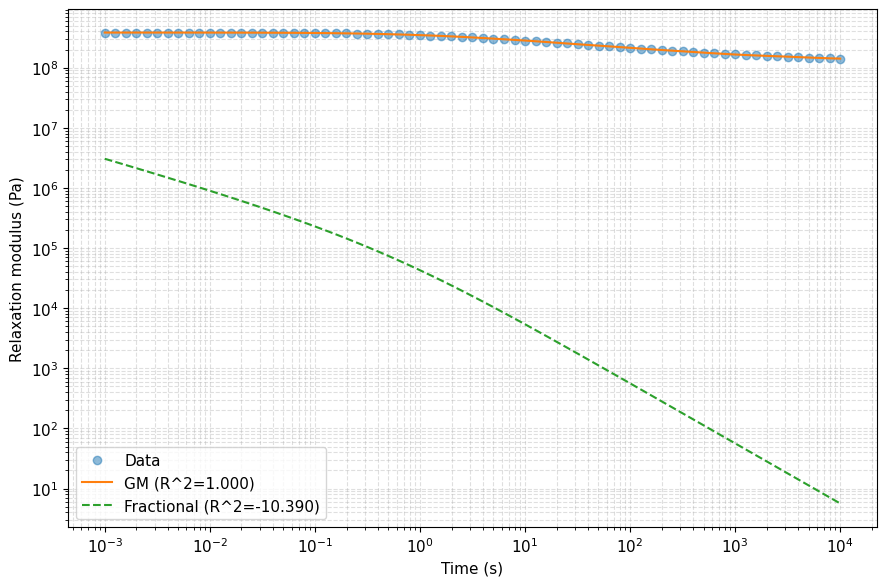

In [5]:
fig, ax = plt.subplots(figsize=(9,6))
ax.loglog(t, G, 'o', label='Data', alpha=0.5)
ax.loglog(t, gm_pred, '-', label=f'GM (R^2={gm_r2:.3f})')
ax.loglog(t, fm_pred, '--', label=f'Fractional (R^2={fm_r2:.3f})')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Relaxation modulus (Pa)')
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend()
plt.tight_layout()
display(fig)
plt.close(fig)

## Bayesian workflow (NLSQ → best model → NUTS diagnostics)

Starting least squares optimization | {'method': 'trf', 'n_params': 13, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.399637s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=28 | final_cost=2.552283e+12 | time=0.400s | final_gradient_norm=4006746800016909.5


Starting least squares optimization | {'method': 'trf', 'n_params': 13, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.360450s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=28 | final_cost=2.552283e+12 | time=0.360s | final_gradient_norm=4006746800016909.5


Starting least squares optimization | {'method': 'trf', 'n_params': 11, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.346447s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=20 | final_cost=8.448174e+12 | time=0.346s | final_gradient_norm=7540514544299808.0


Element minimization: early termination at n_modes=5 (R²=0.999971 < threshold=0.999987)


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


[WARNING] Inner optimization loop hit iteration limit | {'inner_iterations': 100, 'actual_reduction': -1}


Inner optimization loop hit iteration limit | {'inner_iterations': 100, 'actual_reduction': -1}


Timer: optimization took 0.656175s


Convergence: reason=Inner optimization loop exceeded maximum iterations. | iterations=1 | final_cost=3.543309e+01 | time=0.656s | final_gradient_norm=nan


NLSQ hit inner iteration limit; retrying with SciPy least_squares for stability.


Model ranking (R²): [('gm', 1.0), ('fm', -10.39)]


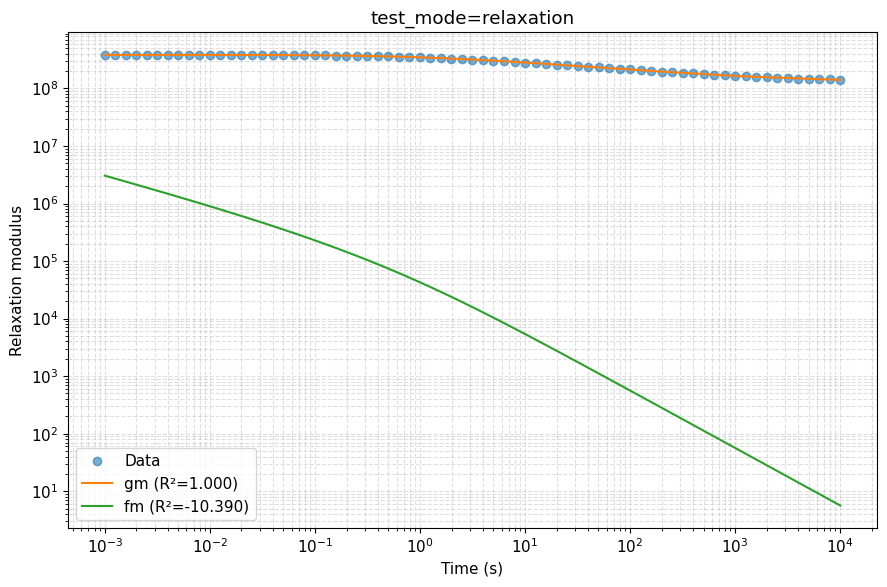

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   0%|          | 1/4000 [00:01<1:07:54,  1.02s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|          | 25/4000 [00:01<02:11, 30.30it/s, 511 steps of size 5.87e-04. acc. prob=0.66]

warmup:   1%|          | 39/4000 [00:01<01:30, 43.98it/s, 3 steps of size 8.83e-05. acc. prob=0.68]  

warmup:   1%|▏         | 52/4000 [00:01<01:08, 57.60it/s, 1023 steps of size 4.13e-04. acc. prob=0.72]

warmup:   2%|▏         | 65/4000 [00:01<01:01, 64.23it/s, 1023 steps of size 4.57e-04. acc. prob=0.73]

warmup:   2%|▏         | 76/4000 [00:01<00:56, 68.94it/s, 1023 steps of size 4.52e-04. acc. prob=0.74]

warmup:   2%|▏         | 86/4000 [00:01<00:56, 69.36it/s, 1023 steps of size 4.82e-04. acc. prob=0.74]

warmup:   2%|▏         | 99/4000 [00:01<00:48, 79.99it/s, 1023 steps of size 3.20e-04. acc. prob=0.74]

warmup:   3%|▎         | 109/4000 [00:02<00:46, 83.90it/s, 255 steps of size 2.26e-02. acc. prob=0.75]

warmup:   3%|▎         | 119/4000 [00:02<00:44, 87.48it/s, 511 steps of size 1.63e-02. acc. prob=0.76]

warmup:   3%|▎         | 131/4000 [00:02<00:40, 94.47it/s, 1023 steps of size 1.39e-02. acc. prob=0.76]

warmup:   4%|▎         | 142/4000 [00:02<00:40, 95.74it/s, 895 steps of size 1.32e-02. acc. prob=0.76] 

warmup:   4%|▍         | 160/4000 [00:02<00:33, 115.04it/s, 1023 steps of size 6.22e-03. acc. prob=0.76]

warmup:   4%|▍         | 173/4000 [00:02<00:32, 118.04it/s, 1023 steps of size 5.18e-03. acc. prob=0.76]

warmup:   5%|▍         | 186/4000 [00:02<00:31, 119.62it/s, 511 steps of size 2.30e-02. acc. prob=0.77] 

warmup:   5%|▌         | 202/4000 [00:02<00:29, 130.26it/s, 127 steps of size 1.73e-02. acc. prob=0.77]

warmup:   5%|▌         | 218/4000 [00:02<00:27, 136.78it/s, 1023 steps of size 8.31e-03. acc. prob=0.77]

warmup:   6%|▌         | 233/4000 [00:02<00:27, 135.74it/s, 1023 steps of size 5.52e-03. acc. prob=0.77]

warmup:   6%|▌         | 248/4000 [00:03<00:27, 136.27it/s, 511 steps of size 1.34e-02. acc. prob=0.77] 

warmup:   7%|▋         | 262/4000 [00:03<00:28, 133.32it/s, 511 steps of size 6.89e-03. acc. prob=0.77]

warmup:   7%|▋         | 276/4000 [00:03<00:27, 133.09it/s, 383 steps of size 2.16e-02. acc. prob=0.77]

warmup:   7%|▋         | 290/4000 [00:03<00:28, 130.57it/s, 511 steps of size 1.81e-02. acc. prob=0.77]

warmup:   8%|▊         | 304/4000 [00:03<00:29, 127.28it/s, 3 steps of size 4.04e-03. acc. prob=0.77]  

warmup:   8%|▊         | 317/4000 [00:03<00:31, 118.70it/s, 1023 steps of size 5.01e-03. acc. prob=0.77]

warmup:   8%|▊         | 329/4000 [00:03<00:30, 118.55it/s, 511 steps of size 1.19e-02. acc. prob=0.78] 

warmup:   9%|▊         | 348/4000 [00:03<00:27, 135.00it/s, 511 steps of size 8.02e-03. acc. prob=0.78]

warmup:   9%|▉         | 363/4000 [00:03<00:26, 138.33it/s, 255 steps of size 1.17e-02. acc. prob=0.78]

warmup:   9%|▉         | 379/4000 [00:04<00:25, 143.87it/s, 255 steps of size 1.98e-02. acc. prob=0.78]

warmup:  10%|▉         | 399/4000 [00:04<00:23, 156.22it/s, 767 steps of size 1.47e-02. acc. prob=0.78]

warmup:  10%|█         | 419/4000 [00:04<00:21, 167.67it/s, 255 steps of size 1.80e-02. acc. prob=0.78]

warmup:  11%|█         | 438/4000 [00:04<00:20, 170.94it/s, 511 steps of size 7.79e-03. acc. prob=0.78]

warmup:  12%|█▏        | 462/4000 [00:04<00:19, 181.65it/s, 1023 steps of size 3.14e-03. acc. prob=0.78]

warmup:  12%|█▏        | 481/4000 [00:04<00:21, 163.02it/s, 1023 steps of size 3.58e-03. acc. prob=0.78]

warmup:  12%|█▏        | 498/4000 [00:04<00:22, 153.84it/s, 511 steps of size 9.56e-03. acc. prob=0.78] 

warmup:  13%|█▎        | 514/4000 [00:04<00:22, 155.06it/s, 511 steps of size 1.34e-02. acc. prob=0.78]

warmup:  13%|█▎        | 530/4000 [00:04<00:22, 154.94it/s, 255 steps of size 1.47e-02. acc. prob=0.78]

warmup:  14%|█▍        | 551/4000 [00:05<00:20, 169.00it/s, 255 steps of size 6.50e-03. acc. prob=0.78]

warmup:  14%|█▍        | 569/4000 [00:05<00:20, 163.97it/s, 5 steps of size 9.35e-03. acc. prob=0.78]  

warmup:  15%|█▍        | 586/4000 [00:05<00:21, 162.44it/s, 255 steps of size 1.09e-02. acc. prob=0.78]

warmup:  15%|█▌        | 603/4000 [00:05<00:20, 161.98it/s, 511 steps of size 9.29e-03. acc. prob=0.78]

warmup:  16%|█▌        | 620/4000 [00:05<00:22, 151.21it/s, 511 steps of size 1.01e-02. acc. prob=0.78]

warmup:  16%|█▌        | 638/4000 [00:05<00:21, 155.09it/s, 511 steps of size 1.36e-02. acc. prob=0.79]

warmup:  16%|█▋        | 656/4000 [00:05<00:20, 160.29it/s, 255 steps of size 1.89e-02. acc. prob=0.79]

warmup:  17%|█▋        | 676/4000 [00:05<00:19, 170.44it/s, 127 steps of size 1.13e-02. acc. prob=0.79]

warmup:  17%|█▋        | 697/4000 [00:05<00:18, 181.35it/s, 127 steps of size 7.84e-03. acc. prob=0.79]

warmup:  18%|█▊        | 716/4000 [00:06<00:19, 168.33it/s, 255 steps of size 9.70e-03. acc. prob=0.79]

warmup:  18%|█▊        | 735/4000 [00:06<00:18, 172.68it/s, 255 steps of size 1.50e-02. acc. prob=0.79]

warmup:  19%|█▉        | 753/4000 [00:06<00:18, 174.31it/s, 255 steps of size 1.33e-02. acc. prob=0.79]

warmup:  19%|█▉        | 776/4000 [00:06<00:17, 184.29it/s, 1023 steps of size 1.02e-02. acc. prob=0.79]

warmup:  20%|█▉        | 796/4000 [00:06<00:17, 187.99it/s, 127 steps of size 1.36e-02. acc. prob=0.79] 

warmup:  20%|██        | 815/4000 [00:06<00:17, 182.45it/s, 15 steps of size 1.25e-02. acc. prob=0.79] 

warmup:  21%|██        | 834/4000 [00:06<00:18, 171.68it/s, 511 steps of size 8.85e-03. acc. prob=0.79]

warmup:  21%|██▏       | 852/4000 [00:06<00:18, 172.95it/s, 255 steps of size 1.15e-02. acc. prob=0.79]

warmup:  22%|██▏       | 871/4000 [00:06<00:17, 175.91it/s, 511 steps of size 9.93e-03. acc. prob=0.79]

warmup:  22%|██▏       | 891/4000 [00:07<00:17, 177.72it/s, 1023 steps of size 1.06e-02. acc. prob=0.79]

warmup:  23%|██▎       | 910/4000 [00:07<00:17, 180.14it/s, 255 steps of size 1.25e-02. acc. prob=0.79] 

warmup:  23%|██▎       | 929/4000 [00:07<00:17, 172.69it/s, 511 steps of size 1.56e-02. acc. prob=0.79]

warmup:  24%|██▍       | 954/4000 [00:07<00:16, 184.85it/s, 1023 steps of size 3.37e-03. acc. prob=0.79]

warmup:  24%|██▍       | 973/4000 [00:07<00:20, 148.24it/s, 1023 steps of size 9.78e-03. acc. prob=0.79]

warmup:  25%|██▍       | 989/4000 [00:07<00:22, 135.84it/s, 255 steps of size 2.64e-02. acc. prob=0.79] 

sample:  25%|██▌       | 1004/4000 [00:07<00:22, 132.18it/s, 511 steps of size 8.80e-03. acc. prob=0.97]

sample:  26%|██▌       | 1020/4000 [00:07<00:21, 136.93it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  26%|██▌       | 1036/4000 [00:08<00:21, 140.76it/s, 767 steps of size 8.80e-03. acc. prob=0.94]

sample:  26%|██▋       | 1051/4000 [00:08<00:22, 133.49it/s, 255 steps of size 8.80e-03. acc. prob=0.93]

sample:  27%|██▋       | 1065/4000 [00:08<00:21, 134.16it/s, 255 steps of size 8.80e-03. acc. prob=0.93]

sample:  27%|██▋       | 1079/4000 [00:08<00:21, 135.40it/s, 255 steps of size 8.80e-03. acc. prob=0.94]

sample:  27%|██▋       | 1093/4000 [00:08<00:22, 131.58it/s, 255 steps of size 8.80e-03. acc. prob=0.93]

sample:  28%|██▊       | 1107/4000 [00:08<00:22, 131.03it/s, 255 steps of size 8.80e-03. acc. prob=0.94]

sample:  28%|██▊       | 1122/4000 [00:08<00:21, 135.25it/s, 511 steps of size 8.80e-03. acc. prob=0.93]

sample:  28%|██▊       | 1136/4000 [00:08<00:21, 131.67it/s, 895 steps of size 8.80e-03. acc. prob=0.93]

sample:  29%|██▉       | 1152/4000 [00:08<00:20, 138.71it/s, 255 steps of size 8.80e-03. acc. prob=0.93]

sample:  29%|██▉       | 1166/4000 [00:09<00:20, 137.46it/s, 511 steps of size 8.80e-03. acc. prob=0.93]

sample:  30%|██▉       | 1180/4000 [00:09<00:20, 137.34it/s, 511 steps of size 8.80e-03. acc. prob=0.93]

sample:  30%|██▉       | 1196/4000 [00:09<00:19, 142.25it/s, 511 steps of size 8.80e-03. acc. prob=0.93]

sample:  30%|███       | 1211/4000 [00:09<00:19, 143.26it/s, 319 steps of size 8.80e-03. acc. prob=0.93]

sample:  31%|███       | 1226/4000 [00:09<00:19, 142.22it/s, 255 steps of size 8.80e-03. acc. prob=0.94]

sample:  31%|███       | 1241/4000 [00:09<00:19, 141.10it/s, 639 steps of size 8.80e-03. acc. prob=0.94]

sample:  31%|███▏      | 1257/4000 [00:09<00:18, 145.72it/s, 255 steps of size 8.80e-03. acc. prob=0.94]

sample:  32%|███▏      | 1273/4000 [00:09<00:18, 147.13it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  32%|███▏      | 1288/4000 [00:09<00:19, 141.69it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  33%|███▎      | 1303/4000 [00:10<00:19, 137.10it/s, 767 steps of size 8.80e-03. acc. prob=0.93]

sample:  33%|███▎      | 1317/4000 [00:10<00:21, 124.16it/s, 255 steps of size 8.80e-03. acc. prob=0.94]

sample:  33%|███▎      | 1331/4000 [00:10<00:21, 126.72it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  34%|███▎      | 1344/4000 [00:10<00:21, 125.87it/s, 319 steps of size 8.80e-03. acc. prob=0.94]

sample:  34%|███▍      | 1357/4000 [00:10<00:22, 119.82it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  34%|███▍      | 1371/4000 [00:10<00:21, 123.52it/s, 1023 steps of size 8.80e-03. acc. prob=0.94]

sample:  35%|███▍      | 1389/4000 [00:10<00:18, 138.86it/s, 255 steps of size 8.80e-03. acc. prob=0.93] 

sample:  35%|███▌      | 1405/4000 [00:10<00:17, 144.45it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  36%|███▌      | 1420/4000 [00:10<00:18, 140.94it/s, 255 steps of size 8.80e-03. acc. prob=0.94]

sample:  36%|███▌      | 1436/4000 [00:11<00:17, 146.25it/s, 255 steps of size 8.80e-03. acc. prob=0.94]

sample:  36%|███▋      | 1451/4000 [00:11<00:19, 129.88it/s, 255 steps of size 8.80e-03. acc. prob=0.94]

sample:  37%|███▋      | 1466/4000 [00:11<00:19, 133.33it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  37%|███▋      | 1480/4000 [00:11<00:21, 119.54it/s, 767 steps of size 8.80e-03. acc. prob=0.93]

sample:  37%|███▋      | 1496/4000 [00:11<00:19, 126.91it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  38%|███▊      | 1511/4000 [00:11<00:18, 132.04it/s, 255 steps of size 8.80e-03. acc. prob=0.94]

sample:  38%|███▊      | 1525/4000 [00:11<00:19, 127.09it/s, 207 steps of size 8.80e-03. acc. prob=0.94]

sample:  39%|███▊      | 1541/4000 [00:11<00:18, 135.12it/s, 255 steps of size 8.80e-03. acc. prob=0.94]

sample:  39%|███▉      | 1555/4000 [00:11<00:18, 135.44it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  39%|███▉      | 1569/4000 [00:12<00:18, 132.31it/s, 127 steps of size 8.80e-03. acc. prob=0.94]

sample:  40%|███▉      | 1584/4000 [00:12<00:17, 136.54it/s, 255 steps of size 8.80e-03. acc. prob=0.94]

sample:  40%|███▉      | 1598/4000 [00:12<00:18, 129.50it/s, 95 steps of size 8.80e-03. acc. prob=0.93] 

sample:  40%|████      | 1613/4000 [00:12<00:17, 133.64it/s, 255 steps of size 8.80e-03. acc. prob=0.93]

sample:  41%|████      | 1628/4000 [00:12<00:17, 136.39it/s, 511 steps of size 8.80e-03. acc. prob=0.93]

sample:  41%|████      | 1642/4000 [00:12<00:18, 130.87it/s, 511 steps of size 8.80e-03. acc. prob=0.93]

sample:  41%|████▏     | 1658/4000 [00:12<00:17, 135.17it/s, 767 steps of size 8.80e-03. acc. prob=0.93]

sample:  42%|████▏     | 1672/4000 [00:12<00:17, 136.23it/s, 127 steps of size 8.80e-03. acc. prob=0.93]

sample:  42%|████▏     | 1686/4000 [00:12<00:17, 134.13it/s, 703 steps of size 8.80e-03. acc. prob=0.93]

sample:  42%|████▎     | 1700/4000 [00:13<00:17, 132.88it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  43%|████▎     | 1714/4000 [00:13<00:17, 131.22it/s, 1023 steps of size 8.80e-03. acc. prob=0.94]

sample:  43%|████▎     | 1731/4000 [00:13<00:16, 140.95it/s, 511 steps of size 8.80e-03. acc. prob=0.94] 

sample:  44%|████▎     | 1747/4000 [00:13<00:16, 140.58it/s, 1023 steps of size 8.80e-03. acc. prob=0.94]

sample:  44%|████▍     | 1762/4000 [00:13<00:16, 138.17it/s, 255 steps of size 8.80e-03. acc. prob=0.94] 

sample:  44%|████▍     | 1776/4000 [00:13<00:16, 134.91it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  45%|████▍     | 1790/4000 [00:13<00:16, 134.00it/s, 255 steps of size 8.80e-03. acc. prob=0.94]

sample:  45%|████▌     | 1804/4000 [00:13<00:16, 134.50it/s, 383 steps of size 8.80e-03. acc. prob=0.94]

sample:  45%|████▌     | 1818/4000 [00:13<00:17, 125.74it/s, 575 steps of size 8.80e-03. acc. prob=0.94]

sample:  46%|████▌     | 1832/4000 [00:14<00:17, 127.04it/s, 1023 steps of size 8.80e-03. acc. prob=0.93]

sample:  46%|████▌     | 1845/4000 [00:14<00:17, 126.64it/s, 255 steps of size 8.80e-03. acc. prob=0.94] 

sample:  46%|████▋     | 1859/4000 [00:14<00:16, 129.05it/s, 383 steps of size 8.80e-03. acc. prob=0.93]

sample:  47%|████▋     | 1874/4000 [00:14<00:15, 134.35it/s, 255 steps of size 8.80e-03. acc. prob=0.93]

sample:  47%|████▋     | 1888/4000 [00:14<00:16, 129.23it/s, 511 steps of size 8.80e-03. acc. prob=0.93]

sample:  48%|████▊     | 1904/4000 [00:14<00:15, 135.45it/s, 511 steps of size 8.80e-03. acc. prob=0.93]

sample:  48%|████▊     | 1919/4000 [00:14<00:15, 136.36it/s, 767 steps of size 8.80e-03. acc. prob=0.93]

sample:  48%|████▊     | 1934/4000 [00:14<00:15, 134.88it/s, 1023 steps of size 8.80e-03. acc. prob=0.93]

sample:  49%|████▉     | 1950/4000 [00:14<00:14, 141.55it/s, 255 steps of size 8.80e-03. acc. prob=0.93] 

sample:  49%|████▉     | 1965/4000 [00:14<00:14, 142.68it/s, 127 steps of size 8.80e-03. acc. prob=0.93]

sample:  50%|████▉     | 1980/4000 [00:15<00:14, 139.64it/s, 767 steps of size 8.80e-03. acc. prob=0.93]

sample:  50%|████▉     | 1995/4000 [00:15<00:15, 126.56it/s, 1023 steps of size 8.80e-03. acc. prob=0.93]

sample:  50%|█████     | 2008/4000 [00:15<00:15, 126.31it/s, 255 steps of size 8.80e-03. acc. prob=0.93] 

sample:  51%|█████     | 2024/4000 [00:15<00:15, 130.86it/s, 1023 steps of size 8.80e-03. acc. prob=0.93]

sample:  51%|█████     | 2038/4000 [00:15<00:15, 129.27it/s, 511 steps of size 8.80e-03. acc. prob=0.93] 

sample:  51%|█████▏    | 2052/4000 [00:15<00:15, 128.41it/s, 255 steps of size 8.80e-03. acc. prob=0.93]

sample:  52%|█████▏    | 2067/4000 [00:15<00:14, 132.19it/s, 511 steps of size 8.80e-03. acc. prob=0.93]

sample:  52%|█████▏    | 2081/4000 [00:15<00:15, 126.44it/s, 511 steps of size 8.80e-03. acc. prob=0.93]

sample:  52%|█████▏    | 2094/4000 [00:16<00:15, 124.20it/s, 255 steps of size 8.80e-03. acc. prob=0.93]

sample:  53%|█████▎    | 2107/4000 [00:16<00:15, 122.37it/s, 1023 steps of size 8.80e-03. acc. prob=0.94]

sample:  53%|█████▎    | 2120/4000 [00:16<00:16, 116.37it/s, 511 steps of size 8.80e-03. acc. prob=0.94] 

sample:  53%|█████▎    | 2133/4000 [00:16<00:15, 118.99it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  54%|█████▎    | 2148/4000 [00:16<00:14, 125.86it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  54%|█████▍    | 2163/4000 [00:16<00:14, 130.26it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  54%|█████▍    | 2177/4000 [00:16<00:13, 131.01it/s, 1023 steps of size 8.80e-03. acc. prob=0.94]

sample:  55%|█████▍    | 2192/4000 [00:16<00:13, 134.88it/s, 255 steps of size 8.80e-03. acc. prob=0.94] 

sample:  55%|█████▌    | 2207/4000 [00:16<00:12, 138.09it/s, 335 steps of size 8.80e-03. acc. prob=0.94]

sample:  56%|█████▌    | 2221/4000 [00:17<00:13, 131.72it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  56%|█████▌    | 2235/4000 [00:17<00:13, 130.25it/s, 639 steps of size 8.80e-03. acc. prob=0.94]

sample:  56%|█████▌    | 2249/4000 [00:17<00:13, 125.63it/s, 255 steps of size 8.80e-03. acc. prob=0.94]

sample:  57%|█████▋    | 2262/4000 [00:17<00:13, 124.36it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  57%|█████▋    | 2276/4000 [00:17<00:13, 127.68it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  57%|█████▋    | 2289/4000 [00:17<00:13, 126.90it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  58%|█████▊    | 2306/4000 [00:17<00:12, 137.70it/s, 255 steps of size 8.80e-03. acc. prob=0.94]

sample:  58%|█████▊    | 2320/4000 [00:17<00:12, 132.11it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  58%|█████▊    | 2334/4000 [00:17<00:13, 127.20it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  59%|█████▊    | 2347/4000 [00:18<00:13, 126.93it/s, 95 steps of size 8.80e-03. acc. prob=0.94] 

sample:  59%|█████▉    | 2360/4000 [00:18<00:13, 124.71it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  59%|█████▉    | 2374/4000 [00:18<00:12, 127.04it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  60%|█████▉    | 2387/4000 [00:18<00:12, 124.08it/s, 255 steps of size 8.80e-03. acc. prob=0.94]

sample:  60%|██████    | 2404/4000 [00:18<00:11, 134.86it/s, 1023 steps of size 8.80e-03. acc. prob=0.94]

sample:  60%|██████    | 2418/4000 [00:18<00:12, 130.48it/s, 511 steps of size 8.80e-03. acc. prob=0.94] 

sample:  61%|██████    | 2433/4000 [00:18<00:11, 134.42it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  61%|██████▏   | 2451/4000 [00:18<00:10, 143.46it/s, 479 steps of size 8.80e-03. acc. prob=0.94]

sample:  62%|██████▏   | 2466/4000 [00:18<00:11, 136.24it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  62%|██████▏   | 2480/4000 [00:18<00:11, 132.94it/s, 383 steps of size 8.80e-03. acc. prob=0.94]

sample:  62%|██████▏   | 2494/4000 [00:19<00:11, 129.43it/s, 479 steps of size 8.80e-03. acc. prob=0.94]

sample:  63%|██████▎   | 2507/4000 [00:19<00:11, 128.78it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  63%|██████▎   | 2520/4000 [00:19<00:11, 126.02it/s, 255 steps of size 8.80e-03. acc. prob=0.94]

sample:  63%|██████▎   | 2533/4000 [00:19<00:11, 126.47it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  64%|██████▎   | 2546/4000 [00:19<00:11, 122.80it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  64%|██████▍   | 2559/4000 [00:19<00:11, 122.04it/s, 255 steps of size 8.80e-03. acc. prob=0.94]

sample:  64%|██████▍   | 2572/4000 [00:19<00:12, 118.16it/s, 255 steps of size 8.80e-03. acc. prob=0.94]

sample:  65%|██████▍   | 2586/4000 [00:19<00:11, 122.63it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  65%|██████▍   | 2599/4000 [00:19<00:11, 119.13it/s, 255 steps of size 8.80e-03. acc. prob=0.94]

sample:  65%|██████▌   | 2611/4000 [00:20<00:11, 118.82it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  66%|██████▌   | 2623/4000 [00:20<00:12, 113.40it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  66%|██████▌   | 2637/4000 [00:20<00:11, 119.99it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  66%|██████▋   | 2656/4000 [00:20<00:09, 137.69it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  67%|██████▋   | 2671/4000 [00:20<00:09, 136.42it/s, 1023 steps of size 8.80e-03. acc. prob=0.94]

sample:  67%|██████▋   | 2685/4000 [00:20<00:09, 134.68it/s, 511 steps of size 8.80e-03. acc. prob=0.94] 

sample:  67%|██████▋   | 2699/4000 [00:20<00:10, 128.90it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  68%|██████▊   | 2712/4000 [00:20<00:10, 127.94it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  68%|██████▊   | 2727/4000 [00:20<00:09, 132.87it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  69%|██████▊   | 2741/4000 [00:21<00:09, 130.14it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  69%|██████▉   | 2758/4000 [00:21<00:08, 141.06it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  69%|██████▉   | 2773/4000 [00:21<00:08, 140.23it/s, 255 steps of size 8.80e-03. acc. prob=0.94]

sample:  70%|██████▉   | 2791/4000 [00:21<00:08, 151.07it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  70%|███████   | 2807/4000 [00:21<00:08, 148.92it/s, 255 steps of size 8.80e-03. acc. prob=0.94]

sample:  71%|███████   | 2825/4000 [00:21<00:07, 157.21it/s, 255 steps of size 8.80e-03. acc. prob=0.94]

sample:  71%|███████   | 2841/4000 [00:21<00:07, 146.72it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  71%|███████▏  | 2859/4000 [00:21<00:07, 152.99it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  72%|███████▏  | 2875/4000 [00:21<00:07, 145.04it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  72%|███████▏  | 2890/4000 [00:22<00:08, 128.28it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  73%|███████▎  | 2904/4000 [00:22<00:08, 127.77it/s, 703 steps of size 8.80e-03. acc. prob=0.94]

sample:  73%|███████▎  | 2920/4000 [00:22<00:07, 135.82it/s, 31 steps of size 8.80e-03. acc. prob=0.94] 

sample:  73%|███████▎  | 2935/4000 [00:22<00:07, 137.10it/s, 1023 steps of size 8.80e-03. acc. prob=0.94]

sample:  74%|███████▎  | 2949/4000 [00:22<00:07, 133.66it/s, 511 steps of size 8.80e-03. acc. prob=0.94] 

sample:  74%|███████▍  | 2963/4000 [00:22<00:07, 133.15it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  74%|███████▍  | 2977/4000 [00:22<00:07, 132.58it/s, 639 steps of size 8.80e-03. acc. prob=0.94]

sample:  75%|███████▍  | 2993/4000 [00:22<00:07, 139.20it/s, 255 steps of size 8.80e-03. acc. prob=0.94]

sample:  75%|███████▌  | 3008/4000 [00:22<00:06, 142.26it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  76%|███████▌  | 3023/4000 [00:23<00:07, 134.16it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  76%|███████▌  | 3037/4000 [00:23<00:07, 127.06it/s, 1023 steps of size 8.80e-03. acc. prob=0.94]

sample:  76%|███████▋  | 3053/4000 [00:23<00:07, 134.69it/s, 1023 steps of size 8.80e-03. acc. prob=0.94]

sample:  77%|███████▋  | 3068/4000 [00:23<00:06, 135.74it/s, 511 steps of size 8.80e-03. acc. prob=0.94] 

sample:  77%|███████▋  | 3082/4000 [00:23<00:06, 131.61it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  77%|███████▋  | 3097/4000 [00:23<00:06, 134.42it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  78%|███████▊  | 3113/4000 [00:23<00:06, 139.33it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  78%|███████▊  | 3132/4000 [00:23<00:05, 148.41it/s, 767 steps of size 8.80e-03. acc. prob=0.94]

sample:  79%|███████▊  | 3148/4000 [00:23<00:05, 148.82it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  79%|███████▉  | 3163/4000 [00:24<00:06, 136.48it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  79%|███████▉  | 3177/4000 [00:24<00:06, 135.34it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  80%|███████▉  | 3191/4000 [00:24<00:06, 134.69it/s, 767 steps of size 8.80e-03. acc. prob=0.94]

sample:  80%|████████  | 3205/4000 [00:24<00:05, 135.13it/s, 255 steps of size 8.80e-03. acc. prob=0.94]

sample:  80%|████████  | 3219/4000 [00:24<00:06, 127.36it/s, 255 steps of size 8.80e-03. acc. prob=0.94]

sample:  81%|████████  | 3232/4000 [00:24<00:06, 121.91it/s, 255 steps of size 8.80e-03. acc. prob=0.94]

sample:  81%|████████  | 3248/4000 [00:24<00:05, 129.63it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  82%|████████▏ | 3262/4000 [00:24<00:05, 126.60it/s, 767 steps of size 8.80e-03. acc. prob=0.94]

sample:  82%|████████▏ | 3275/4000 [00:24<00:05, 126.47it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  82%|████████▏ | 3290/4000 [00:25<00:05, 128.77it/s, 1023 steps of size 8.80e-03. acc. prob=0.94]

sample:  83%|████████▎ | 3304/4000 [00:25<00:05, 129.58it/s, 767 steps of size 8.80e-03. acc. prob=0.94] 

sample:  83%|████████▎ | 3320/4000 [00:25<00:04, 136.83it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  83%|████████▎ | 3334/4000 [00:25<00:05, 129.36it/s, 767 steps of size 8.80e-03. acc. prob=0.94]

sample:  84%|████████▎ | 3348/4000 [00:25<00:05, 125.04it/s, 351 steps of size 8.80e-03. acc. prob=0.94]

sample:  84%|████████▍ | 3362/4000 [00:25<00:04, 129.04it/s, 255 steps of size 8.80e-03. acc. prob=0.94]

sample:  84%|████████▍ | 3376/4000 [00:25<00:05, 122.66it/s, 1023 steps of size 8.80e-03. acc. prob=0.94]

sample:  85%|████████▍ | 3391/4000 [00:25<00:04, 129.68it/s, 255 steps of size 8.80e-03. acc. prob=0.94] 

sample:  85%|████████▌ | 3405/4000 [00:25<00:04, 125.69it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  85%|████████▌ | 3418/4000 [00:26<00:04, 125.25it/s, 767 steps of size 8.80e-03. acc. prob=0.94]

sample:  86%|████████▌ | 3431/4000 [00:26<00:04, 124.05it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  86%|████████▌ | 3446/4000 [00:26<00:04, 129.94it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  86%|████████▋ | 3460/4000 [00:26<00:04, 124.65it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  87%|████████▋ | 3473/4000 [00:26<00:04, 119.38it/s, 959 steps of size 8.80e-03. acc. prob=0.94]

sample:  87%|████████▋ | 3486/4000 [00:26<00:04, 116.14it/s, 255 steps of size 8.80e-03. acc. prob=0.94]

sample:  88%|████████▊ | 3500/4000 [00:26<00:04, 119.77it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  88%|████████▊ | 3513/4000 [00:26<00:04, 118.18it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  88%|████████▊ | 3532/4000 [00:27<00:03, 135.34it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  89%|████████▊ | 3546/4000 [00:27<00:03, 135.12it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  89%|████████▉ | 3560/4000 [00:27<00:03, 129.17it/s, 351 steps of size 8.80e-03. acc. prob=0.94]

sample:  89%|████████▉ | 3574/4000 [00:27<00:03, 125.23it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  90%|████████▉ | 3590/4000 [00:27<00:03, 134.34it/s, 255 steps of size 8.80e-03. acc. prob=0.94]

sample:  90%|█████████ | 3604/4000 [00:27<00:02, 135.39it/s, 255 steps of size 8.80e-03. acc. prob=0.94]

sample:  90%|█████████ | 3618/4000 [00:27<00:02, 133.51it/s, 287 steps of size 8.80e-03. acc. prob=0.94]

sample:  91%|█████████ | 3635/4000 [00:27<00:02, 143.87it/s, 255 steps of size 8.80e-03. acc. prob=0.94]

sample:  91%|█████████▏| 3652/4000 [00:27<00:02, 151.37it/s, 255 steps of size 8.80e-03. acc. prob=0.94]

sample:  92%|█████████▏| 3668/4000 [00:28<00:02, 131.99it/s, 1023 steps of size 8.80e-03. acc. prob=0.94]

sample:  92%|█████████▏| 3682/4000 [00:28<00:02, 128.11it/s, 607 steps of size 8.80e-03. acc. prob=0.94] 

sample:  92%|█████████▏| 3699/4000 [00:28<00:02, 136.98it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  93%|█████████▎| 3714/4000 [00:28<00:02, 124.22it/s, 1023 steps of size 8.80e-03. acc. prob=0.94]

sample:  93%|█████████▎| 3727/4000 [00:28<00:02, 118.43it/s, 511 steps of size 8.80e-03. acc. prob=0.94] 

sample:  94%|█████████▎| 3744/4000 [00:28<00:01, 130.35it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  94%|█████████▍| 3758/4000 [00:28<00:01, 125.38it/s, 287 steps of size 8.80e-03. acc. prob=0.94]

sample:  94%|█████████▍| 3772/4000 [00:28<00:01, 126.78it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  95%|█████████▍| 3786/4000 [00:28<00:01, 128.11it/s, 1023 steps of size 8.80e-03. acc. prob=0.94]

sample:  95%|█████████▌| 3800/4000 [00:29<00:01, 130.21it/s, 511 steps of size 8.80e-03. acc. prob=0.94] 

sample:  95%|█████████▌| 3814/4000 [00:29<00:01, 131.28it/s, 47 steps of size 8.80e-03. acc. prob=0.94] 

sample:  96%|█████████▌| 3828/4000 [00:29<00:01, 127.77it/s, 127 steps of size 8.80e-03. acc. prob=0.94]

sample:  96%|█████████▌| 3845/4000 [00:29<00:01, 136.23it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  96%|█████████▋| 3859/4000 [00:29<00:01, 135.51it/s, 255 steps of size 8.80e-03. acc. prob=0.94]

sample:  97%|█████████▋| 3873/4000 [00:29<00:00, 131.26it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  97%|█████████▋| 3889/4000 [00:29<00:00, 135.78it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  98%|█████████▊| 3903/4000 [00:29<00:00, 127.10it/s, 255 steps of size 8.80e-03. acc. prob=0.94]

sample:  98%|█████████▊| 3917/4000 [00:29<00:00, 127.17it/s, 767 steps of size 8.80e-03. acc. prob=0.94]

sample:  98%|█████████▊| 3930/4000 [00:30<00:00, 127.33it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  99%|█████████▊| 3943/4000 [00:30<00:00, 125.44it/s, 511 steps of size 8.80e-03. acc. prob=0.94]

sample:  99%|█████████▉| 3959/4000 [00:30<00:00, 130.01it/s, 1023 steps of size 8.80e-03. acc. prob=0.94]

sample:  99%|█████████▉| 3975/4000 [00:30<00:00, 137.04it/s, 511 steps of size 8.80e-03. acc. prob=0.94] 

sample: 100%|█████████▉| 3989/4000 [00:30<00:00, 134.38it/s, 1023 steps of size 8.80e-03. acc. prob=0.94]

sample: 100%|██████████| 4000/4000 [00:30<00:00, 130.86it/s, 511 steps of size 8.80e-03. acc. prob=0.94] 

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   0%|          | 19/4000 [00:00<00:21, 189.36it/s, 1023 steps of size 4.70e-04. acc. prob=0.63]

warmup:   1%|          | 38/4000 [00:00<00:32, 120.26it/s, 511 steps of size 3.31e-04. acc. prob=0.69] 

warmup:   1%|▏         | 52/4000 [00:00<00:33, 117.95it/s, 127 steps of size 9.60e-05. acc. prob=0.70]

warmup:   2%|▏         | 65/4000 [00:00<00:41, 95.96it/s, 1023 steps of size 1.72e-04. acc. prob=0.72]

warmup:   2%|▏         | 76/4000 [00:00<00:41, 95.15it/s, 1023 steps of size 3.22e-04. acc. prob=0.73]

warmup:   2%|▏         | 86/4000 [00:00<00:44, 88.88it/s, 1023 steps of size 5.46e-04. acc. prob=0.74]

warmup:   2%|▏         | 96/4000 [00:00<00:45, 86.45it/s, 255 steps of size 3.03e-04. acc. prob=0.74] 

warmup:   3%|▎         | 105/4000 [00:01<00:47, 82.41it/s, 767 steps of size 7.37e-03. acc. prob=0.75]

warmup:   3%|▎         | 115/4000 [00:01<00:45, 85.66it/s, 1023 steps of size 9.71e-03. acc. prob=0.75]

warmup:   3%|▎         | 127/4000 [00:01<00:41, 92.66it/s, 767 steps of size 8.17e-03. acc. prob=0.76] 

warmup:   3%|▎         | 138/4000 [00:01<00:39, 96.92it/s, 255 steps of size 1.22e-02. acc. prob=0.76]

warmup:   4%|▍         | 155/4000 [00:01<00:33, 114.01it/s, 255 steps of size 2.15e-02. acc. prob=0.76]

warmup:   4%|▍         | 168/4000 [00:01<00:32, 116.38it/s, 511 steps of size 1.86e-02. acc. prob=0.77]

warmup:   4%|▍         | 180/4000 [00:01<00:32, 116.77it/s, 639 steps of size 1.64e-02. acc. prob=0.77]

warmup:   5%|▍         | 197/4000 [00:01<00:29, 129.81it/s, 511 steps of size 2.00e-02. acc. prob=0.77]

warmup:   5%|▌         | 212/4000 [00:01<00:27, 135.53it/s, 255 steps of size 1.01e-02. acc. prob=0.77]

warmup:   6%|▌         | 229/4000 [00:02<00:26, 142.84it/s, 511 steps of size 7.32e-03. acc. prob=0.77]

warmup:   6%|▌         | 244/4000 [00:02<00:27, 136.14it/s, 511 steps of size 1.34e-02. acc. prob=0.77]

warmup:   7%|▋         | 263/4000 [00:02<00:24, 151.00it/s, 59 steps of size 7.87e-03. acc. prob=0.77] 

warmup:   7%|▋         | 279/4000 [00:02<00:24, 149.43it/s, 1023 steps of size 4.76e-03. acc. prob=0.77]

warmup:   7%|▋         | 295/4000 [00:02<00:25, 145.85it/s, 511 steps of size 2.34e-02. acc. prob=0.78] 

warmup:   8%|▊         | 310/4000 [00:02<00:25, 143.04it/s, 511 steps of size 1.55e-02. acc. prob=0.78]

warmup:   8%|▊         | 325/4000 [00:02<00:25, 142.48it/s, 255 steps of size 1.02e-02. acc. prob=0.78]

warmup:   9%|▊         | 344/4000 [00:02<00:23, 154.88it/s, 255 steps of size 2.35e-02. acc. prob=0.78]

warmup:   9%|▉         | 363/4000 [00:02<00:22, 162.89it/s, 255 steps of size 1.37e-02. acc. prob=0.78]

warmup:  10%|▉         | 382/4000 [00:03<00:21, 167.04it/s, 415 steps of size 8.51e-03. acc. prob=0.78]

warmup:  10%|▉         | 399/4000 [00:03<00:22, 157.06it/s, 767 steps of size 1.52e-02. acc. prob=0.78]

warmup:  10%|█         | 417/4000 [00:03<00:22, 162.64it/s, 255 steps of size 1.98e-02. acc. prob=0.78]

warmup:  11%|█         | 434/4000 [00:03<00:22, 159.25it/s, 159 steps of size 1.81e-02. acc. prob=0.78]

warmup:  11%|█▏        | 454/4000 [00:03<00:21, 167.50it/s, 511 steps of size 8.21e-03. acc. prob=0.78]

warmup:  12%|█▏        | 471/4000 [00:03<00:22, 156.69it/s, 1023 steps of size 6.96e-03. acc. prob=0.78]

warmup:  12%|█▏        | 487/4000 [00:03<00:22, 155.78it/s, 1023 steps of size 4.33e-03. acc. prob=0.78]

warmup:  13%|█▎        | 503/4000 [00:03<00:24, 145.15it/s, 255 steps of size 6.68e-03. acc. prob=0.78] 

warmup:  13%|█▎        | 518/4000 [00:03<00:24, 142.33it/s, 767 steps of size 1.22e-02. acc. prob=0.78]

warmup:  13%|█▎        | 533/4000 [00:04<00:24, 143.03it/s, 511 steps of size 8.48e-03. acc. prob=0.78]

warmup:  14%|█▎        | 548/4000 [00:04<00:25, 136.82it/s, 511 steps of size 9.06e-03. acc. prob=0.78]

warmup:  14%|█▍        | 564/4000 [00:04<00:24, 141.49it/s, 255 steps of size 1.41e-02. acc. prob=0.78]

warmup:  15%|█▍        | 582/4000 [00:04<00:22, 149.92it/s, 255 steps of size 1.28e-02. acc. prob=0.78]

warmup:  15%|█▍        | 598/4000 [00:04<00:22, 150.94it/s, 255 steps of size 1.04e-02. acc. prob=0.78]

warmup:  15%|█▌        | 615/4000 [00:04<00:21, 155.40it/s, 255 steps of size 1.04e-02. acc. prob=0.78]

warmup:  16%|█▌        | 631/4000 [00:04<00:21, 154.63it/s, 511 steps of size 1.02e-02. acc. prob=0.78]

warmup:  16%|█▌        | 647/4000 [00:04<00:21, 152.67it/s, 127 steps of size 1.68e-02. acc. prob=0.78]

warmup:  17%|█▋        | 664/4000 [00:04<00:21, 155.10it/s, 383 steps of size 1.85e-02. acc. prob=0.79]

warmup:  17%|█▋        | 686/4000 [00:05<00:19, 173.37it/s, 255 steps of size 1.45e-02. acc. prob=0.79]

warmup:  18%|█▊        | 704/4000 [00:05<00:19, 165.69it/s, 511 steps of size 1.38e-02. acc. prob=0.79]

warmup:  18%|█▊        | 721/4000 [00:05<00:21, 156.04it/s, 153 steps of size 1.53e-02. acc. prob=0.79]

warmup:  18%|█▊        | 739/4000 [00:05<00:20, 161.68it/s, 511 steps of size 1.50e-02. acc. prob=0.79]

warmup:  19%|█▉        | 758/4000 [00:05<00:19, 167.92it/s, 255 steps of size 1.01e-02. acc. prob=0.79]

warmup:  19%|█▉        | 777/4000 [00:05<00:19, 167.15it/s, 1023 steps of size 9.64e-03. acc. prob=0.79]

warmup:  20%|█▉        | 794/4000 [00:05<00:19, 166.87it/s, 511 steps of size 1.15e-02. acc. prob=0.79] 

warmup:  20%|██        | 814/4000 [00:05<00:18, 174.77it/s, 383 steps of size 1.59e-02. acc. prob=0.79]

warmup:  21%|██        | 832/4000 [00:05<00:19, 163.75it/s, 255 steps of size 1.57e-02. acc. prob=0.79]

warmup:  21%|██        | 849/4000 [00:06<00:19, 164.31it/s, 167 steps of size 1.09e-02. acc. prob=0.79]

warmup:  22%|██▏       | 870/4000 [00:06<00:17, 176.18it/s, 255 steps of size 1.04e-02. acc. prob=0.79]

warmup:  22%|██▏       | 891/4000 [00:06<00:16, 184.04it/s, 255 steps of size 1.06e-02. acc. prob=0.79]

warmup:  23%|██▎       | 915/4000 [00:06<00:15, 198.48it/s, 255 steps of size 1.30e-02. acc. prob=0.79]

warmup:  23%|██▎       | 935/4000 [00:06<00:15, 196.39it/s, 255 steps of size 1.80e-02. acc. prob=0.79]

warmup:  24%|██▍       | 955/4000 [00:06<00:16, 183.33it/s, 1023 steps of size 4.47e-03. acc. prob=0.79]

warmup:  24%|██▍       | 974/4000 [00:06<00:19, 157.33it/s, 47 steps of size 2.53e-02. acc. prob=0.79]  

warmup:  25%|██▍       | 991/4000 [00:06<00:20, 144.94it/s, 511 steps of size 1.20e-02. acc. prob=0.79]

sample:  25%|██▌       | 1007/4000 [00:07<00:22, 130.34it/s, 255 steps of size 8.36e-03. acc. prob=0.96]

sample:  26%|██▌       | 1021/4000 [00:07<00:24, 120.40it/s, 1023 steps of size 8.36e-03. acc. prob=0.95]

sample:  26%|██▌       | 1034/4000 [00:07<00:25, 118.07it/s, 511 steps of size 8.36e-03. acc. prob=0.95] 

sample:  26%|██▌       | 1047/4000 [00:07<00:25, 115.02it/s, 511 steps of size 8.36e-03. acc. prob=0.94]

sample:  26%|██▋       | 1060/4000 [00:07<00:24, 118.45it/s, 511 steps of size 8.36e-03. acc. prob=0.94]

sample:  27%|██▋       | 1073/4000 [00:07<00:25, 113.40it/s, 255 steps of size 8.36e-03. acc. prob=0.94]

sample:  27%|██▋       | 1085/4000 [00:07<00:25, 112.15it/s, 511 steps of size 8.36e-03. acc. prob=0.94]

sample:  27%|██▋       | 1097/4000 [00:07<00:26, 110.26it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  28%|██▊       | 1109/4000 [00:07<00:26, 108.46it/s, 1023 steps of size 8.36e-03. acc. prob=0.95]

sample:  28%|██▊       | 1120/4000 [00:08<00:26, 107.45it/s, 767 steps of size 8.36e-03. acc. prob=0.95] 

sample:  28%|██▊       | 1131/4000 [00:08<00:26, 107.26it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  29%|██▊       | 1142/4000 [00:08<00:26, 106.73it/s, 511 steps of size 8.36e-03. acc. prob=0.94]

sample:  29%|██▉       | 1155/4000 [00:08<00:25, 113.17it/s, 255 steps of size 8.36e-03. acc. prob=0.94]

sample:  29%|██▉       | 1171/4000 [00:08<00:22, 125.46it/s, 255 steps of size 8.36e-03. acc. prob=0.94]

sample:  30%|██▉       | 1184/4000 [00:08<00:22, 126.43it/s, 767 steps of size 8.36e-03. acc. prob=0.95]

sample:  30%|██▉       | 1197/4000 [00:08<00:24, 113.47it/s, 255 steps of size 8.36e-03. acc. prob=0.95]

sample:  30%|███       | 1209/4000 [00:08<00:24, 114.12it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  31%|███       | 1221/4000 [00:08<00:24, 111.70it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  31%|███       | 1234/4000 [00:09<00:23, 115.51it/s, 767 steps of size 8.36e-03. acc. prob=0.95]

sample:  31%|███       | 1247/4000 [00:09<00:23, 119.21it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  32%|███▏      | 1260/4000 [00:09<00:23, 118.49it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  32%|███▏      | 1272/4000 [00:09<00:24, 111.77it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  32%|███▏      | 1284/4000 [00:09<00:24, 112.76it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  32%|███▏      | 1296/4000 [00:09<00:25, 106.69it/s, 1023 steps of size 8.36e-03. acc. prob=0.95]

sample:  33%|███▎      | 1309/4000 [00:09<00:24, 112.10it/s, 511 steps of size 8.36e-03. acc. prob=0.95] 

sample:  33%|███▎      | 1322/4000 [00:09<00:23, 116.03it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  33%|███▎      | 1334/4000 [00:09<00:23, 111.55it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  34%|███▎      | 1346/4000 [00:10<00:24, 109.46it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  34%|███▍      | 1358/4000 [00:10<00:23, 112.10it/s, 1023 steps of size 8.36e-03. acc. prob=0.95]

sample:  34%|███▍      | 1370/4000 [00:10<00:23, 113.21it/s, 1023 steps of size 8.36e-03. acc. prob=0.95]

sample:  35%|███▍      | 1382/4000 [00:10<00:23, 113.70it/s, 511 steps of size 8.36e-03. acc. prob=0.95] 

sample:  35%|███▍      | 1394/4000 [00:10<00:24, 106.10it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  35%|███▌      | 1408/4000 [00:10<00:22, 115.16it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  36%|███▌      | 1420/4000 [00:10<00:23, 110.56it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  36%|███▌      | 1435/4000 [00:10<00:21, 120.43it/s, 255 steps of size 8.36e-03. acc. prob=0.95]

sample:  36%|███▌      | 1448/4000 [00:10<00:21, 119.91it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  37%|███▋      | 1461/4000 [00:11<00:22, 114.05it/s, 895 steps of size 8.36e-03. acc. prob=0.95]

sample:  37%|███▋      | 1473/4000 [00:11<00:22, 111.95it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  37%|███▋      | 1485/4000 [00:11<00:23, 109.04it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  37%|███▋      | 1496/4000 [00:11<00:23, 104.55it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  38%|███▊      | 1508/4000 [00:11<00:23, 104.55it/s, 1023 steps of size 8.36e-03. acc. prob=0.95]

sample:  38%|███▊      | 1519/4000 [00:11<00:23, 103.55it/s, 383 steps of size 8.36e-03. acc. prob=0.95] 

sample:  38%|███▊      | 1531/4000 [00:11<00:23, 107.15it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  39%|███▊      | 1542/4000 [00:11<00:23, 106.81it/s, 255 steps of size 8.36e-03. acc. prob=0.95]

sample:  39%|███▉      | 1556/4000 [00:11<00:21, 114.96it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  39%|███▉      | 1568/4000 [00:12<00:21, 110.80it/s, 1023 steps of size 8.36e-03. acc. prob=0.95]

sample:  40%|███▉      | 1583/4000 [00:12<00:20, 120.54it/s, 511 steps of size 8.36e-03. acc. prob=0.95] 

sample:  40%|███▉      | 1597/4000 [00:12<00:19, 124.88it/s, 255 steps of size 8.36e-03. acc. prob=0.95]

sample:  40%|████      | 1610/4000 [00:12<00:19, 120.79it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  41%|████      | 1623/4000 [00:12<00:21, 112.19it/s, 1023 steps of size 8.36e-03. acc. prob=0.95]

sample:  41%|████      | 1635/4000 [00:12<00:21, 108.84it/s, 511 steps of size 8.36e-03. acc. prob=0.95] 

sample:  41%|████      | 1647/4000 [00:12<00:21, 108.19it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  41%|████▏     | 1658/4000 [00:12<00:22, 104.76it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  42%|████▏     | 1670/4000 [00:12<00:21, 107.24it/s, 1023 steps of size 8.36e-03. acc. prob=0.95]

sample:  42%|████▏     | 1682/4000 [00:13<00:21, 107.23it/s, 895 steps of size 8.36e-03. acc. prob=0.95] 

sample:  42%|████▏     | 1695/4000 [00:13<00:20, 112.63it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  43%|████▎     | 1707/4000 [00:13<00:20, 110.00it/s, 1023 steps of size 8.36e-03. acc. prob=0.95]

sample:  43%|████▎     | 1719/4000 [00:13<00:21, 106.00it/s, 767 steps of size 8.36e-03. acc. prob=0.95] 

sample:  43%|████▎     | 1733/4000 [00:13<00:20, 110.78it/s, 1023 steps of size 8.36e-03. acc. prob=0.95]

sample:  44%|████▎     | 1746/4000 [00:13<00:19, 113.87it/s, 511 steps of size 8.36e-03. acc. prob=0.95] 

sample:  44%|████▍     | 1758/4000 [00:13<00:20, 110.92it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  44%|████▍     | 1771/4000 [00:13<00:19, 115.38it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  45%|████▍     | 1787/4000 [00:13<00:17, 125.87it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  45%|████▌     | 1802/4000 [00:14<00:16, 130.66it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  45%|████▌     | 1816/4000 [00:14<00:16, 128.67it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  46%|████▌     | 1830/4000 [00:14<00:16, 130.05it/s, 767 steps of size 8.36e-03. acc. prob=0.95]

sample:  46%|████▌     | 1844/4000 [00:14<00:16, 129.31it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  46%|████▋     | 1857/4000 [00:14<00:17, 124.09it/s, 255 steps of size 8.36e-03. acc. prob=0.95]

sample:  47%|████▋     | 1870/4000 [00:14<00:17, 119.32it/s, 767 steps of size 8.36e-03. acc. prob=0.95]

sample:  47%|████▋     | 1884/4000 [00:14<00:17, 121.60it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  47%|████▋     | 1897/4000 [00:14<00:17, 121.35it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  48%|████▊     | 1910/4000 [00:14<00:18, 111.41it/s, 255 steps of size 8.36e-03. acc. prob=0.95]

sample:  48%|████▊     | 1923/4000 [00:15<00:17, 115.99it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  48%|████▊     | 1935/4000 [00:15<00:18, 114.10it/s, 1023 steps of size 8.36e-03. acc. prob=0.95]

sample:  49%|████▊     | 1947/4000 [00:15<00:18, 113.48it/s, 1023 steps of size 8.36e-03. acc. prob=0.95]

sample:  49%|████▉     | 1962/4000 [00:15<00:16, 120.38it/s, 511 steps of size 8.36e-03. acc. prob=0.95] 

sample:  49%|████▉     | 1978/4000 [00:15<00:15, 131.19it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  50%|████▉     | 1992/4000 [00:15<00:15, 126.67it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  50%|█████     | 2005/4000 [00:15<00:17, 112.89it/s, 1023 steps of size 8.36e-03. acc. prob=0.95]

sample:  50%|█████     | 2018/4000 [00:15<00:17, 115.19it/s, 511 steps of size 8.36e-03. acc. prob=0.95] 

sample:  51%|█████     | 2032/4000 [00:15<00:16, 121.10it/s, 543 steps of size 8.36e-03. acc. prob=0.95]

sample:  51%|█████     | 2045/4000 [00:16<00:15, 122.48it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  52%|█████▏    | 2060/4000 [00:16<00:15, 127.12it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  52%|█████▏    | 2073/4000 [00:16<00:15, 121.70it/s, 1023 steps of size 8.36e-03. acc. prob=0.95]

sample:  52%|█████▏    | 2086/4000 [00:16<00:15, 119.87it/s, 511 steps of size 8.36e-03. acc. prob=0.95] 

sample:  52%|█████▏    | 2099/4000 [00:16<00:15, 119.38it/s, 255 steps of size 8.36e-03. acc. prob=0.95]

sample:  53%|█████▎    | 2112/4000 [00:16<00:15, 120.78it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  53%|█████▎    | 2125/4000 [00:16<00:16, 110.42it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  53%|█████▎    | 2138/4000 [00:16<00:16, 115.51it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  54%|█████▍    | 2153/4000 [00:16<00:15, 122.02it/s, 831 steps of size 8.36e-03. acc. prob=0.95]

sample:  54%|█████▍    | 2166/4000 [00:17<00:16, 113.84it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  54%|█████▍    | 2178/4000 [00:17<00:15, 115.33it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  55%|█████▍    | 2190/4000 [00:17<00:16, 111.63it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  55%|█████▌    | 2202/4000 [00:17<00:16, 109.62it/s, 767 steps of size 8.36e-03. acc. prob=0.95]

sample:  55%|█████▌    | 2215/4000 [00:17<00:16, 110.78it/s, 1023 steps of size 8.36e-03. acc. prob=0.95]

sample:  56%|█████▌    | 2227/4000 [00:17<00:16, 105.73it/s, 255 steps of size 8.36e-03. acc. prob=0.95] 

sample:  56%|█████▌    | 2241/4000 [00:17<00:15, 114.79it/s, 383 steps of size 8.36e-03. acc. prob=0.95]

sample:  56%|█████▋    | 2254/4000 [00:17<00:14, 117.50it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  57%|█████▋    | 2266/4000 [00:18<00:15, 111.18it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  57%|█████▋    | 2278/4000 [00:18<00:15, 113.46it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  57%|█████▋    | 2290/4000 [00:18<00:15, 112.26it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  58%|█████▊    | 2302/4000 [00:18<00:15, 109.07it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  58%|█████▊    | 2315/4000 [00:18<00:15, 112.18it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  58%|█████▊    | 2329/4000 [00:18<00:14, 117.29it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  59%|█████▊    | 2341/4000 [00:18<00:14, 112.84it/s, 1023 steps of size 8.36e-03. acc. prob=0.95]

sample:  59%|█████▉    | 2353/4000 [00:18<00:14, 113.98it/s, 1023 steps of size 8.36e-03. acc. prob=0.95]

sample:  59%|█████▉    | 2365/4000 [00:18<00:15, 104.66it/s, 511 steps of size 8.36e-03. acc. prob=0.95] 

sample:  59%|█████▉    | 2376/4000 [00:19<00:15, 104.54it/s, 959 steps of size 8.36e-03. acc. prob=0.95]

sample:  60%|█████▉    | 2387/4000 [00:19<00:15, 101.16it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  60%|█████▉    | 2398/4000 [00:19<00:15, 103.05it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  60%|██████    | 2411/4000 [00:19<00:14, 106.88it/s, 1023 steps of size 8.36e-03. acc. prob=0.95]

sample:  61%|██████    | 2425/4000 [00:19<00:13, 115.04it/s, 767 steps of size 8.36e-03. acc. prob=0.95] 

sample:  61%|██████    | 2437/4000 [00:19<00:13, 113.32it/s, 767 steps of size 8.36e-03. acc. prob=0.95]

sample:  61%|██████▏   | 2450/4000 [00:19<00:13, 117.33it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  62%|██████▏   | 2463/4000 [00:19<00:12, 118.72it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  62%|██████▏   | 2475/4000 [00:19<00:13, 113.93it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  62%|██████▏   | 2487/4000 [00:19<00:13, 114.49it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  62%|██████▏   | 2499/4000 [00:20<00:13, 113.39it/s, 127 steps of size 8.36e-03. acc. prob=0.95]

sample:  63%|██████▎   | 2513/4000 [00:20<00:12, 119.93it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  63%|██████▎   | 2526/4000 [00:20<00:12, 113.60it/s, 767 steps of size 8.36e-03. acc. prob=0.95]

sample:  63%|██████▎   | 2539/4000 [00:20<00:12, 115.22it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  64%|██████▍   | 2551/4000 [00:20<00:12, 112.03it/s, 1023 steps of size 8.36e-03. acc. prob=0.95]

sample:  64%|██████▍   | 2568/4000 [00:20<00:11, 122.40it/s, 1023 steps of size 8.36e-03. acc. prob=0.95]

sample:  65%|██████▍   | 2581/4000 [00:20<00:11, 121.52it/s, 511 steps of size 8.36e-03. acc. prob=0.95] 

sample:  65%|██████▍   | 2594/4000 [00:20<00:11, 121.60it/s, 511 steps of size 8.36e-03. acc. prob=0.96]

sample:  65%|██████▌   | 2607/4000 [00:21<00:11, 116.23it/s, 255 steps of size 8.36e-03. acc. prob=0.96]

sample:  65%|██████▌   | 2619/4000 [00:21<00:11, 115.32it/s, 511 steps of size 8.36e-03. acc. prob=0.96]

sample:  66%|██████▌   | 2632/4000 [00:21<00:11, 117.97it/s, 767 steps of size 8.36e-03. acc. prob=0.96]

sample:  66%|██████▌   | 2648/4000 [00:21<00:10, 125.24it/s, 1023 steps of size 8.36e-03. acc. prob=0.95]

sample:  67%|██████▋   | 2664/4000 [00:21<00:09, 134.33it/s, 255 steps of size 8.36e-03. acc. prob=0.95] 

sample:  67%|██████▋   | 2678/4000 [00:21<00:09, 134.98it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  67%|██████▋   | 2694/4000 [00:21<00:09, 141.71it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  68%|██████▊   | 2709/4000 [00:21<00:09, 137.82it/s, 63 steps of size 8.36e-03. acc. prob=0.95] 

sample:  68%|██████▊   | 2723/4000 [00:21<00:09, 137.68it/s, 767 steps of size 8.36e-03. acc. prob=0.95]

sample:  68%|██████▊   | 2738/4000 [00:21<00:09, 136.52it/s, 767 steps of size 8.36e-03. acc. prob=0.95]

sample:  69%|██████▉   | 2754/4000 [00:22<00:09, 138.35it/s, 799 steps of size 8.36e-03. acc. prob=0.95]

sample:  69%|██████▉   | 2771/4000 [00:22<00:08, 147.03it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  70%|██████▉   | 2786/4000 [00:22<00:08, 143.00it/s, 319 steps of size 8.36e-03. acc. prob=0.95]

sample:  70%|███████   | 2801/4000 [00:22<00:08, 144.14it/s, 255 steps of size 8.36e-03. acc. prob=0.95]

sample:  70%|███████   | 2816/4000 [00:22<00:08, 139.49it/s, 63 steps of size 8.36e-03. acc. prob=0.95] 

sample:  71%|███████   | 2831/4000 [00:22<00:08, 140.37it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  71%|███████   | 2846/4000 [00:22<00:08, 137.21it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  72%|███████▏  | 2860/4000 [00:22<00:09, 120.49it/s, 255 steps of size 8.36e-03. acc. prob=0.95]

sample:  72%|███████▏  | 2874/4000 [00:22<00:09, 124.67it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  72%|███████▏  | 2887/4000 [00:23<00:08, 125.74it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  72%|███████▎  | 2900/4000 [00:23<00:08, 123.74it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  73%|███████▎  | 2913/4000 [00:23<00:08, 124.59it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  73%|███████▎  | 2927/4000 [00:23<00:08, 123.80it/s, 1023 steps of size 8.36e-03. acc. prob=0.95]

sample:  74%|███████▎  | 2940/4000 [00:23<00:08, 124.59it/s, 255 steps of size 8.36e-03. acc. prob=0.95] 

sample:  74%|███████▍  | 2953/4000 [00:23<00:08, 122.96it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  74%|███████▍  | 2966/4000 [00:23<00:09, 113.40it/s, 927 steps of size 8.36e-03. acc. prob=0.95]

sample:  74%|███████▍  | 2980/4000 [00:23<00:08, 118.14it/s, 1023 steps of size 8.36e-03. acc. prob=0.95]

sample:  75%|███████▍  | 2992/4000 [00:23<00:08, 113.51it/s, 255 steps of size 8.36e-03. acc. prob=0.95] 

sample:  75%|███████▌  | 3004/4000 [00:24<00:09, 105.44it/s, 1023 steps of size 8.36e-03. acc. prob=0.95]

sample:  75%|███████▌  | 3018/4000 [00:24<00:08, 113.25it/s, 255 steps of size 8.36e-03. acc. prob=0.95] 

sample:  76%|███████▌  | 3032/4000 [00:24<00:08, 120.37it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  76%|███████▌  | 3046/4000 [00:24<00:07, 119.97it/s, 1023 steps of size 8.36e-03. acc. prob=0.95]

sample:  77%|███████▋  | 3061/4000 [00:24<00:07, 126.21it/s, 575 steps of size 8.36e-03. acc. prob=0.95] 

sample:  77%|███████▋  | 3074/4000 [00:24<00:07, 125.18it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  77%|███████▋  | 3087/4000 [00:24<00:07, 121.57it/s, 255 steps of size 8.36e-03. acc. prob=0.95]

sample:  78%|███████▊  | 3100/4000 [00:24<00:07, 120.23it/s, 255 steps of size 8.36e-03. acc. prob=0.95]

sample:  78%|███████▊  | 3113/4000 [00:24<00:07, 120.64it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  78%|███████▊  | 3126/4000 [00:25<00:07, 115.45it/s, 255 steps of size 8.36e-03. acc. prob=0.95]

sample:  78%|███████▊  | 3139/4000 [00:25<00:07, 116.55it/s, 767 steps of size 8.36e-03. acc. prob=0.95]

sample:  79%|███████▉  | 3151/4000 [00:25<00:07, 114.31it/s, 1023 steps of size 8.36e-03. acc. prob=0.95]

sample:  79%|███████▉  | 3165/4000 [00:25<00:06, 119.37it/s, 511 steps of size 8.36e-03. acc. prob=0.95] 

sample:  80%|███████▉  | 3180/4000 [00:25<00:06, 122.70it/s, 1023 steps of size 8.36e-03. acc. prob=0.95]

sample:  80%|███████▉  | 3193/4000 [00:25<00:06, 119.15it/s, 1023 steps of size 8.36e-03. acc. prob=0.95]

sample:  80%|████████  | 3205/4000 [00:25<00:07, 110.09it/s, 511 steps of size 8.36e-03. acc. prob=0.95] 

sample:  80%|████████  | 3217/4000 [00:25<00:07, 111.71it/s, 367 steps of size 8.36e-03. acc. prob=0.95]

sample:  81%|████████  | 3229/4000 [00:26<00:06, 111.39it/s, 703 steps of size 8.36e-03. acc. prob=0.95]

sample:  81%|████████  | 3244/4000 [00:26<00:06, 121.05it/s, 255 steps of size 8.36e-03. acc. prob=0.95]

sample:  82%|████████▏ | 3260/4000 [00:26<00:05, 130.20it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  82%|████████▏ | 3274/4000 [00:26<00:05, 131.17it/s, 255 steps of size 8.36e-03. acc. prob=0.95]

sample:  82%|████████▏ | 3288/4000 [00:26<00:05, 130.11it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  83%|████████▎ | 3302/4000 [00:26<00:05, 128.89it/s, 447 steps of size 8.36e-03. acc. prob=0.95]

sample:  83%|████████▎ | 3315/4000 [00:26<00:05, 120.93it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  83%|████████▎ | 3328/4000 [00:26<00:05, 113.52it/s, 767 steps of size 8.36e-03. acc. prob=0.95]

sample:  84%|████████▎ | 3340/4000 [00:26<00:05, 113.88it/s, 255 steps of size 8.36e-03. acc. prob=0.95]

sample:  84%|████████▍ | 3352/4000 [00:27<00:05, 111.09it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  84%|████████▍ | 3364/4000 [00:27<00:05, 110.82it/s, 767 steps of size 8.36e-03. acc. prob=0.95]

sample:  84%|████████▍ | 3376/4000 [00:27<00:05, 109.97it/s, 1023 steps of size 8.36e-03. acc. prob=0.95]

sample:  85%|████████▍ | 3390/4000 [00:27<00:05, 118.03it/s, 639 steps of size 8.36e-03. acc. prob=0.95] 

sample:  85%|████████▌ | 3405/4000 [00:27<00:04, 125.31it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  85%|████████▌ | 3418/4000 [00:27<00:05, 114.78it/s, 1023 steps of size 8.36e-03. acc. prob=0.95]

sample:  86%|████████▌ | 3430/4000 [00:27<00:05, 113.79it/s, 255 steps of size 8.36e-03. acc. prob=0.95] 

sample:  86%|████████▌ | 3445/4000 [00:27<00:04, 120.98it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  86%|████████▋ | 3458/4000 [00:27<00:04, 121.13it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  87%|████████▋ | 3473/4000 [00:28<00:04, 129.17it/s, 255 steps of size 8.36e-03. acc. prob=0.95]

sample:  87%|████████▋ | 3487/4000 [00:28<00:03, 130.00it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  88%|████████▊ | 3501/4000 [00:28<00:03, 126.21it/s, 255 steps of size 8.36e-03. acc. prob=0.95]

sample:  88%|████████▊ | 3514/4000 [00:28<00:04, 116.31it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  88%|████████▊ | 3527/4000 [00:28<00:03, 119.04it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  89%|████████▊ | 3541/4000 [00:28<00:03, 124.77it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  89%|████████▉ | 3554/4000 [00:28<00:03, 119.14it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  89%|████████▉ | 3567/4000 [00:28<00:03, 117.72it/s, 1023 steps of size 8.36e-03. acc. prob=0.95]

sample:  90%|████████▉ | 3581/4000 [00:28<00:03, 121.72it/s, 1023 steps of size 8.36e-03. acc. prob=0.95]

sample:  90%|████████▉ | 3596/4000 [00:29<00:03, 129.53it/s, 511 steps of size 8.36e-03. acc. prob=0.95] 

sample:  90%|█████████ | 3610/4000 [00:29<00:03, 128.71it/s, 255 steps of size 8.36e-03. acc. prob=0.95]

sample:  91%|█████████ | 3623/4000 [00:29<00:03, 125.22it/s, 255 steps of size 8.36e-03. acc. prob=0.95]

sample:  91%|█████████ | 3639/4000 [00:29<00:02, 132.12it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  91%|█████████▏| 3653/4000 [00:29<00:02, 121.09it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  92%|█████████▏| 3666/4000 [00:29<00:02, 117.92it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  92%|█████████▏| 3679/4000 [00:29<00:02, 119.16it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  92%|█████████▏| 3692/4000 [00:29<00:02, 116.36it/s, 383 steps of size 8.36e-03. acc. prob=0.95]

sample:  93%|█████████▎| 3706/4000 [00:29<00:02, 122.57it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  93%|█████████▎| 3719/4000 [00:30<00:02, 112.78it/s, 1023 steps of size 8.36e-03. acc. prob=0.95]

sample:  93%|█████████▎| 3731/4000 [00:30<00:02, 114.19it/s, 511 steps of size 8.36e-03. acc. prob=0.95] 

sample:  94%|█████████▎| 3743/4000 [00:30<00:02, 114.15it/s, 127 steps of size 8.36e-03. acc. prob=0.96]

sample:  94%|█████████▍| 3755/4000 [00:30<00:02, 113.23it/s, 511 steps of size 8.36e-03. acc. prob=0.96]

sample:  94%|█████████▍| 3767/4000 [00:30<00:02, 115.04it/s, 511 steps of size 8.36e-03. acc. prob=0.95]

sample:  94%|█████████▍| 3780/4000 [00:30<00:01, 118.57it/s, 767 steps of size 8.36e-03. acc. prob=0.96]

sample:  95%|█████████▍| 3792/4000 [00:30<00:01, 109.71it/s, 1023 steps of size 8.36e-03. acc. prob=0.96]

sample:  95%|█████████▌| 3804/4000 [00:30<00:01, 104.38it/s, 511 steps of size 8.36e-03. acc. prob=0.96] 

sample:  95%|█████████▌| 3815/4000 [00:30<00:01, 105.75it/s, 511 steps of size 8.36e-03. acc. prob=0.96]

sample:  96%|█████████▌| 3826/4000 [00:31<00:01, 103.18it/s, 511 steps of size 8.36e-03. acc. prob=0.96]

sample:  96%|█████████▌| 3837/4000 [00:31<00:01, 104.42it/s, 191 steps of size 8.36e-03. acc. prob=0.96]

sample:  96%|█████████▋| 3850/4000 [00:31<00:01, 110.26it/s, 607 steps of size 8.36e-03. acc. prob=0.96]

sample:  97%|█████████▋| 3862/4000 [00:31<00:01, 112.01it/s, 511 steps of size 8.36e-03. acc. prob=0.96]

sample:  97%|█████████▋| 3874/4000 [00:31<00:01, 105.10it/s, 255 steps of size 8.36e-03. acc. prob=0.96]

sample:  97%|█████████▋| 3887/4000 [00:31<00:01, 110.09it/s, 511 steps of size 8.36e-03. acc. prob=0.96]

sample:  98%|█████████▊| 3902/4000 [00:31<00:00, 120.65it/s, 767 steps of size 8.36e-03. acc. prob=0.96]

sample:  98%|█████████▊| 3915/4000 [00:31<00:00, 118.93it/s, 255 steps of size 8.36e-03. acc. prob=0.96]

sample:  98%|█████████▊| 3928/4000 [00:31<00:00, 118.98it/s, 159 steps of size 8.36e-03. acc. prob=0.96]

sample:  98%|█████████▊| 3940/4000 [00:32<00:00, 112.02it/s, 255 steps of size 8.36e-03. acc. prob=0.96]

sample:  99%|█████████▉| 3952/4000 [00:32<00:00, 102.59it/s, 1023 steps of size 8.36e-03. acc. prob=0.96]

sample:  99%|█████████▉| 3963/4000 [00:32<00:00, 101.66it/s, 1023 steps of size 8.36e-03. acc. prob=0.96]

sample:  99%|█████████▉| 3976/4000 [00:32<00:00, 106.86it/s, 511 steps of size 8.36e-03. acc. prob=0.96] 

sample: 100%|█████████▉| 3989/4000 [00:32<00:00, 112.70it/s, 511 steps of size 8.36e-03. acc. prob=0.96]

sample: 100%|██████████| 4000/4000 [00:32<00:00, 122.70it/s, 511 steps of size 8.36e-03. acc. prob=0.96]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   1%|          | 28/4000 [00:00<00:14, 274.75it/s, 1023 steps of size 2.28e-04. acc. prob=0.66]

warmup:   1%|▏         | 56/4000 [00:00<00:32, 120.27it/s, 255 steps of size 3.07e-04. acc. prob=0.72] 

warmup:   2%|▏         | 73/4000 [00:00<00:39, 99.63it/s, 1023 steps of size 1.22e-04. acc. prob=0.72]

warmup:   2%|▏         | 86/4000 [00:00<00:39, 98.17it/s, 1023 steps of size 3.08e-04. acc. prob=0.74]

warmup:   2%|▏         | 98/4000 [00:00<00:41, 94.38it/s, 1023 steps of size 2.20e-04. acc. prob=0.74]

warmup:   3%|▎         | 109/4000 [00:01<00:39, 97.53it/s, 255 steps of size 2.61e-02. acc. prob=0.75]

warmup:   3%|▎         | 126/4000 [00:01<00:34, 111.41it/s, 1023 steps of size 8.13e-03. acc. prob=0.76]

warmup:   3%|▎         | 138/4000 [00:01<00:36, 106.70it/s, 255 steps of size 2.39e-02. acc. prob=0.76] 

warmup:   4%|▍         | 151/4000 [00:01<00:34, 112.06it/s, 383 steps of size 6.63e-02. acc. prob=0.76]

warmup:   4%|▍         | 163/4000 [00:01<00:35, 107.66it/s, 1023 steps of size 5.43e-03. acc. prob=0.76]

warmup:   4%|▍         | 175/4000 [00:01<00:35, 109.18it/s, 127 steps of size 1.65e-02. acc. prob=0.77] 

warmup:   5%|▍         | 188/4000 [00:01<00:34, 111.45it/s, 1023 steps of size 1.28e-02. acc. prob=0.77]

warmup:   5%|▌         | 201/4000 [00:01<00:33, 114.32it/s, 1023 steps of size 1.34e-02. acc. prob=0.77]

warmup:   5%|▌         | 215/4000 [00:01<00:31, 119.00it/s, 767 steps of size 1.57e-02. acc. prob=0.77] 

warmup:   6%|▌         | 228/4000 [00:02<00:33, 111.26it/s, 191 steps of size 2.22e-02. acc. prob=0.77]

warmup:   6%|▌         | 243/4000 [00:02<00:30, 121.54it/s, 1023 steps of size 8.15e-03. acc. prob=0.77]

warmup:   6%|▋         | 259/4000 [00:02<00:28, 129.09it/s, 511 steps of size 2.24e-02. acc. prob=0.77] 

warmup:   7%|▋         | 273/4000 [00:02<00:28, 131.53it/s, 1023 steps of size 5.95e-03. acc. prob=0.77]

warmup:   7%|▋         | 287/4000 [00:02<00:28, 130.92it/s, 511 steps of size 1.49e-02. acc. prob=0.77] 

warmup:   8%|▊         | 303/4000 [00:02<00:26, 138.50it/s, 511 steps of size 1.65e-02. acc. prob=0.78]

warmup:   8%|▊         | 317/4000 [00:02<00:27, 134.84it/s, 255 steps of size 2.88e-02. acc. prob=0.78]

warmup:   8%|▊         | 331/4000 [00:02<00:27, 135.78it/s, 511 steps of size 2.06e-02. acc. prob=0.78]

warmup:   9%|▊         | 345/4000 [00:02<00:26, 136.04it/s, 511 steps of size 1.72e-02. acc. prob=0.78]

warmup:   9%|▉         | 363/4000 [00:03<00:24, 147.79it/s, 511 steps of size 1.33e-02. acc. prob=0.78]

warmup:   9%|▉         | 378/4000 [00:03<00:25, 140.63it/s, 511 steps of size 1.65e-02. acc. prob=0.78]

warmup:  10%|▉         | 394/4000 [00:03<00:24, 145.72it/s, 511 steps of size 9.05e-03. acc. prob=0.78]

warmup:  10%|█         | 412/4000 [00:03<00:23, 155.06it/s, 127 steps of size 2.99e-02. acc. prob=0.78]

warmup:  11%|█         | 435/4000 [00:03<00:20, 173.34it/s, 511 steps of size 1.53e-02. acc. prob=0.78]

warmup:  11%|█▏        | 453/4000 [00:03<00:21, 168.50it/s, 511 steps of size 1.81e-02. acc. prob=0.78]

warmup:  12%|█▏        | 470/4000 [00:03<00:22, 155.18it/s, 1023 steps of size 6.98e-03. acc. prob=0.78]

warmup:  12%|█▏        | 486/4000 [00:03<00:23, 152.60it/s, 511 steps of size 5.83e-03. acc. prob=0.78] 

warmup:  13%|█▎        | 502/4000 [00:03<00:22, 152.51it/s, 255 steps of size 1.80e-02. acc. prob=0.78]

warmup:  13%|█▎        | 518/4000 [00:04<00:24, 141.70it/s, 1023 steps of size 1.09e-02. acc. prob=0.78]

warmup:  13%|█▎        | 537/4000 [00:04<00:22, 151.97it/s, 511 steps of size 1.36e-02. acc. prob=0.78] 

warmup:  14%|█▍        | 553/4000 [00:04<00:22, 151.25it/s, 255 steps of size 1.28e-02. acc. prob=0.78]

warmup:  14%|█▍        | 570/4000 [00:04<00:22, 150.92it/s, 1023 steps of size 1.08e-02. acc. prob=0.78]

warmup:  15%|█▍        | 586/4000 [00:04<00:23, 148.08it/s, 255 steps of size 1.03e-02. acc. prob=0.78] 

warmup:  15%|█▌        | 602/4000 [00:04<00:22, 150.91it/s, 127 steps of size 9.60e-03. acc. prob=0.78]

warmup:  15%|█▌        | 619/4000 [00:04<00:21, 155.65it/s, 111 steps of size 1.33e-02. acc. prob=0.78]

warmup:  16%|█▌        | 636/4000 [00:04<00:21, 159.18it/s, 127 steps of size 1.68e-02. acc. prob=0.79]

warmup:  16%|█▋        | 652/4000 [00:04<00:21, 156.92it/s, 255 steps of size 8.83e-03. acc. prob=0.78]

warmup:  17%|█▋        | 672/4000 [00:04<00:19, 168.11it/s, 511 steps of size 1.64e-02. acc. prob=0.79]

warmup:  17%|█▋        | 691/4000 [00:05<00:19, 170.23it/s, 511 steps of size 1.35e-02. acc. prob=0.79]

warmup:  18%|█▊        | 709/4000 [00:05<00:19, 168.39it/s, 511 steps of size 1.28e-02. acc. prob=0.79]

warmup:  18%|█▊        | 727/4000 [00:05<00:19, 170.95it/s, 127 steps of size 1.70e-02. acc. prob=0.79]

warmup:  19%|█▊        | 746/4000 [00:05<00:18, 174.89it/s, 511 steps of size 1.30e-02. acc. prob=0.79]

warmup:  19%|█▉        | 766/4000 [00:05<00:17, 181.38it/s, 207 steps of size 1.41e-02. acc. prob=0.79]

warmup:  20%|█▉        | 786/4000 [00:05<00:17, 184.00it/s, 511 steps of size 1.81e-02. acc. prob=0.79]

warmup:  20%|██        | 805/4000 [00:05<00:19, 167.51it/s, 255 steps of size 1.46e-02. acc. prob=0.79]

warmup:  21%|██        | 826/4000 [00:05<00:17, 176.93it/s, 255 steps of size 9.85e-03. acc. prob=0.79]

warmup:  21%|██        | 847/4000 [00:05<00:17, 185.32it/s, 255 steps of size 1.76e-02. acc. prob=0.79]

warmup:  22%|██▏       | 868/4000 [00:06<00:16, 190.37it/s, 255 steps of size 1.21e-02. acc. prob=0.79]

warmup:  22%|██▏       | 889/4000 [00:06<00:15, 195.76it/s, 255 steps of size 1.28e-02. acc. prob=0.79]

warmup:  23%|██▎       | 909/4000 [00:06<00:17, 179.38it/s, 767 steps of size 1.21e-02. acc. prob=0.79]

warmup:  23%|██▎       | 928/4000 [00:06<00:17, 175.53it/s, 383 steps of size 1.54e-02. acc. prob=0.79]

warmup:  24%|██▎       | 949/4000 [00:06<00:16, 182.67it/s, 511 steps of size 1.16e-02. acc. prob=0.79]

warmup:  24%|██▍       | 968/4000 [00:06<00:19, 159.46it/s, 767 steps of size 9.52e-03. acc. prob=0.79]

warmup:  25%|██▍       | 985/4000 [00:06<00:19, 152.60it/s, 255 steps of size 1.02e-02. acc. prob=0.79]

sample:  25%|██▌       | 1001/4000 [00:06<00:19, 154.21it/s, 767 steps of size 1.05e-02. acc. prob=1.00]

sample:  26%|██▌       | 1021/4000 [00:06<00:18, 164.88it/s, 255 steps of size 1.05e-02. acc. prob=0.88]

sample:  26%|██▌       | 1038/4000 [00:07<00:17, 165.82it/s, 767 steps of size 1.05e-02. acc. prob=0.90]

sample:  26%|██▋       | 1055/4000 [00:07<00:17, 165.85it/s, 255 steps of size 1.05e-02. acc. prob=0.89]

sample:  27%|██▋       | 1072/4000 [00:07<00:17, 165.32it/s, 255 steps of size 1.05e-02. acc. prob=0.90]

sample:  27%|██▋       | 1089/4000 [00:07<00:18, 154.15it/s, 1023 steps of size 1.05e-02. acc. prob=0.90]

sample:  28%|██▊       | 1107/4000 [00:07<00:18, 156.93it/s, 767 steps of size 1.05e-02. acc. prob=0.90] 

sample:  28%|██▊       | 1126/4000 [00:07<00:17, 162.83it/s, 511 steps of size 1.05e-02. acc. prob=0.91]

sample:  29%|██▊       | 1143/4000 [00:07<00:18, 156.73it/s, 255 steps of size 1.05e-02. acc. prob=0.91]

sample:  29%|██▉       | 1161/4000 [00:07<00:17, 161.17it/s, 511 steps of size 1.05e-02. acc. prob=0.90]

sample:  29%|██▉       | 1178/4000 [00:07<00:18, 153.13it/s, 511 steps of size 1.05e-02. acc. prob=0.90]

sample:  30%|██▉       | 1197/4000 [00:08<00:17, 161.81it/s, 639 steps of size 1.05e-02. acc. prob=0.91]

sample:  30%|███       | 1214/4000 [00:08<00:18, 154.16it/s, 255 steps of size 1.05e-02. acc. prob=0.91]

sample:  31%|███       | 1230/4000 [00:08<00:17, 154.33it/s, 767 steps of size 1.05e-02. acc. prob=0.91]

sample:  31%|███       | 1246/4000 [00:08<00:17, 155.42it/s, 255 steps of size 1.05e-02. acc. prob=0.91]

sample:  32%|███▏      | 1262/4000 [00:08<00:18, 151.11it/s, 511 steps of size 1.05e-02. acc. prob=0.91]

sample:  32%|███▏      | 1278/4000 [00:08<00:18, 146.41it/s, 511 steps of size 1.05e-02. acc. prob=0.91]

sample:  32%|███▏      | 1294/4000 [00:08<00:18, 143.06it/s, 1023 steps of size 1.05e-02. acc. prob=0.91]

sample:  33%|███▎      | 1312/4000 [00:08<00:17, 150.18it/s, 511 steps of size 1.05e-02. acc. prob=0.91] 

sample:  33%|███▎      | 1328/4000 [00:09<00:18, 140.70it/s, 255 steps of size 1.05e-02. acc. prob=0.91]

sample:  34%|███▎      | 1344/4000 [00:09<00:18, 144.08it/s, 511 steps of size 1.05e-02. acc. prob=0.91]

sample:  34%|███▍      | 1362/4000 [00:09<00:17, 151.65it/s, 511 steps of size 1.05e-02. acc. prob=0.91]

sample:  34%|███▍      | 1378/4000 [00:09<00:18, 138.86it/s, 255 steps of size 1.05e-02. acc. prob=0.91]

sample:  35%|███▍      | 1393/4000 [00:09<00:19, 135.72it/s, 767 steps of size 1.05e-02. acc. prob=0.91]

sample:  35%|███▌      | 1407/4000 [00:09<00:20, 128.84it/s, 255 steps of size 1.05e-02. acc. prob=0.91]

sample:  36%|███▌      | 1422/4000 [00:09<00:19, 133.26it/s, 767 steps of size 1.05e-02. acc. prob=0.91]

sample:  36%|███▌      | 1437/4000 [00:09<00:18, 136.52it/s, 767 steps of size 1.05e-02. acc. prob=0.91]

sample:  36%|███▋      | 1455/4000 [00:09<00:17, 146.01it/s, 511 steps of size 1.05e-02. acc. prob=0.91]

sample:  37%|███▋      | 1471/4000 [00:10<00:17, 147.79it/s, 511 steps of size 1.05e-02. acc. prob=0.91]

sample:  37%|███▋      | 1487/4000 [00:10<00:17, 147.79it/s, 511 steps of size 1.05e-02. acc. prob=0.91]

sample:  38%|███▊      | 1504/4000 [00:10<00:16, 153.75it/s, 511 steps of size 1.05e-02. acc. prob=0.91]

sample:  38%|███▊      | 1520/4000 [00:10<00:17, 144.52it/s, 767 steps of size 1.05e-02. acc. prob=0.91]

sample:  38%|███▊      | 1539/4000 [00:10<00:15, 156.80it/s, 255 steps of size 1.05e-02. acc. prob=0.91]

sample:  39%|███▉      | 1555/4000 [00:10<00:15, 154.47it/s, 255 steps of size 1.05e-02. acc. prob=0.91]

sample:  39%|███▉      | 1571/4000 [00:10<00:16, 150.30it/s, 511 steps of size 1.05e-02. acc. prob=0.91]

sample:  40%|███▉      | 1587/4000 [00:10<00:16, 149.04it/s, 511 steps of size 1.05e-02. acc. prob=0.91]

sample:  40%|████      | 1605/4000 [00:10<00:15, 155.72it/s, 511 steps of size 1.05e-02. acc. prob=0.91]

sample:  41%|████      | 1622/4000 [00:10<00:15, 158.29it/s, 255 steps of size 1.05e-02. acc. prob=0.91]

sample:  41%|████      | 1639/4000 [00:11<00:14, 159.62it/s, 255 steps of size 1.05e-02. acc. prob=0.91]

sample:  41%|████▏     | 1656/4000 [00:11<00:14, 157.00it/s, 511 steps of size 1.05e-02. acc. prob=0.91]

sample:  42%|████▏     | 1672/4000 [00:11<00:14, 155.75it/s, 255 steps of size 1.05e-02. acc. prob=0.91]

sample:  42%|████▏     | 1690/4000 [00:11<00:14, 160.53it/s, 511 steps of size 1.05e-02. acc. prob=0.91]

sample:  43%|████▎     | 1707/4000 [00:11<00:15, 151.97it/s, 1023 steps of size 1.05e-02. acc. prob=0.91]

sample:  43%|████▎     | 1723/4000 [00:11<00:14, 152.18it/s, 255 steps of size 1.05e-02. acc. prob=0.91] 

sample:  44%|████▎     | 1743/4000 [00:11<00:13, 162.14it/s, 511 steps of size 1.05e-02. acc. prob=0.91]

sample:  44%|████▍     | 1762/4000 [00:11<00:13, 169.39it/s, 191 steps of size 1.05e-02. acc. prob=0.91]

sample:  44%|████▍     | 1780/4000 [00:12<00:14, 151.03it/s, 255 steps of size 1.05e-02. acc. prob=0.91]

sample:  45%|████▍     | 1797/4000 [00:12<00:14, 155.81it/s, 511 steps of size 1.05e-02. acc. prob=0.91]

sample:  45%|████▌     | 1813/4000 [00:12<00:14, 155.67it/s, 351 steps of size 1.05e-02. acc. prob=0.91]

sample:  46%|████▌     | 1829/4000 [00:12<00:14, 151.38it/s, 511 steps of size 1.05e-02. acc. prob=0.91]

sample:  46%|████▌     | 1847/4000 [00:12<00:13, 155.62it/s, 511 steps of size 1.05e-02. acc. prob=0.91]

sample:  47%|████▋     | 1863/4000 [00:12<00:14, 145.45it/s, 1023 steps of size 1.05e-02. acc. prob=0.91]

sample:  47%|████▋     | 1878/4000 [00:12<00:14, 146.07it/s, 511 steps of size 1.05e-02. acc. prob=0.91] 

sample:  47%|████▋     | 1893/4000 [00:12<00:14, 144.19it/s, 255 steps of size 1.05e-02. acc. prob=0.91]

sample:  48%|████▊     | 1912/4000 [00:12<00:13, 150.44it/s, 1023 steps of size 1.05e-02. acc. prob=0.91]

sample:  48%|████▊     | 1928/4000 [00:12<00:13, 152.05it/s, 255 steps of size 1.05e-02. acc. prob=0.91] 

sample:  49%|████▊     | 1948/4000 [00:13<00:12, 165.17it/s, 255 steps of size 1.05e-02. acc. prob=0.91]

sample:  49%|████▉     | 1967/4000 [00:13<00:11, 169.52it/s, 511 steps of size 1.05e-02. acc. prob=0.91]

sample:  50%|████▉     | 1985/4000 [00:13<00:13, 151.90it/s, 383 steps of size 1.05e-02. acc. prob=0.91]

sample:  50%|█████     | 2002/4000 [00:13<00:12, 156.17it/s, 255 steps of size 1.05e-02. acc. prob=0.91]

sample:  50%|█████     | 2020/4000 [00:13<00:12, 161.28it/s, 511 steps of size 1.05e-02. acc. prob=0.91]

sample:  51%|█████     | 2037/4000 [00:13<00:12, 160.45it/s, 255 steps of size 1.05e-02. acc. prob=0.91]

sample:  51%|█████▏    | 2054/4000 [00:13<00:12, 161.84it/s, 511 steps of size 1.05e-02. acc. prob=0.91]

sample:  52%|█████▏    | 2072/4000 [00:13<00:11, 162.42it/s, 511 steps of size 1.05e-02. acc. prob=0.91]

sample:  52%|█████▏    | 2089/4000 [00:13<00:11, 161.71it/s, 255 steps of size 1.05e-02. acc. prob=0.91]

sample:  53%|█████▎    | 2106/4000 [00:14<00:12, 151.42it/s, 511 steps of size 1.05e-02. acc. prob=0.91]

sample:  53%|█████▎    | 2122/4000 [00:14<00:13, 141.13it/s, 255 steps of size 1.05e-02. acc. prob=0.91]

sample:  53%|█████▎    | 2137/4000 [00:14<00:13, 140.37it/s, 255 steps of size 1.05e-02. acc. prob=0.91]

sample:  54%|█████▍    | 2154/4000 [00:14<00:12, 145.88it/s, 511 steps of size 1.05e-02. acc. prob=0.91]

sample:  54%|█████▍    | 2171/4000 [00:14<00:12, 151.17it/s, 255 steps of size 1.05e-02. acc. prob=0.91]

sample:  55%|█████▍    | 2187/4000 [00:14<00:11, 151.23it/s, 511 steps of size 1.05e-02. acc. prob=0.91]

sample:  55%|█████▌    | 2203/4000 [00:14<00:11, 150.90it/s, 255 steps of size 1.05e-02. acc. prob=0.91]

sample:  55%|█████▌    | 2219/4000 [00:14<00:11, 151.05it/s, 511 steps of size 1.05e-02. acc. prob=0.91]

sample:  56%|█████▌    | 2236/4000 [00:14<00:11, 153.57it/s, 767 steps of size 1.05e-02. acc. prob=0.91]

sample:  56%|█████▋    | 2256/4000 [00:15<00:10, 164.77it/s, 511 steps of size 1.05e-02. acc. prob=0.91]

sample:  57%|█████▋    | 2273/4000 [00:15<00:10, 161.77it/s, 255 steps of size 1.05e-02. acc. prob=0.91]

sample:  57%|█████▋    | 2290/4000 [00:15<00:10, 160.14it/s, 767 steps of size 1.05e-02. acc. prob=0.91]

sample:  58%|█████▊    | 2307/4000 [00:15<00:11, 152.99it/s, 511 steps of size 1.05e-02. acc. prob=0.91]

sample:  58%|█████▊    | 2325/4000 [00:15<00:10, 155.34it/s, 767 steps of size 1.05e-02. acc. prob=0.91]

sample:  59%|█████▊    | 2341/4000 [00:15<00:10, 152.28it/s, 511 steps of size 1.05e-02. acc. prob=0.91]

sample:  59%|█████▉    | 2362/4000 [00:15<00:09, 166.84it/s, 255 steps of size 1.05e-02. acc. prob=0.92]

sample:  59%|█████▉    | 2379/4000 [00:15<00:09, 165.25it/s, 255 steps of size 1.05e-02. acc. prob=0.92]

sample:  60%|█████▉    | 2396/4000 [00:15<00:09, 164.89it/s, 255 steps of size 1.05e-02. acc. prob=0.92]

sample:  60%|██████    | 2413/4000 [00:16<00:10, 156.83it/s, 383 steps of size 1.05e-02. acc. prob=0.91]

sample:  61%|██████    | 2429/4000 [00:16<00:10, 145.25it/s, 511 steps of size 1.05e-02. acc. prob=0.92]

sample:  61%|██████    | 2445/4000 [00:16<00:10, 148.74it/s, 255 steps of size 1.05e-02. acc. prob=0.92]

sample:  62%|██████▏   | 2464/4000 [00:16<00:09, 159.45it/s, 511 steps of size 1.05e-02. acc. prob=0.92]

sample:  62%|██████▏   | 2481/4000 [00:16<00:09, 158.53it/s, 255 steps of size 1.05e-02. acc. prob=0.92]

sample:  62%|██████▏   | 2498/4000 [00:16<00:09, 157.94it/s, 767 steps of size 1.05e-02. acc. prob=0.92]

sample:  63%|██████▎   | 2514/4000 [00:16<00:09, 153.44it/s, 127 steps of size 1.05e-02. acc. prob=0.92]

sample:  63%|██████▎   | 2530/4000 [00:16<00:10, 143.78it/s, 511 steps of size 1.05e-02. acc. prob=0.92]

sample:  64%|██████▎   | 2545/4000 [00:16<00:10, 136.08it/s, 255 steps of size 1.05e-02. acc. prob=0.92]

sample:  64%|██████▍   | 2559/4000 [00:17<00:10, 135.18it/s, 415 steps of size 1.05e-02. acc. prob=0.92]

sample:  64%|██████▍   | 2576/4000 [00:17<00:09, 143.65it/s, 255 steps of size 1.05e-02. acc. prob=0.92]

sample:  65%|██████▍   | 2596/4000 [00:17<00:08, 157.12it/s, 511 steps of size 1.05e-02. acc. prob=0.92]

sample:  65%|██████▌   | 2614/4000 [00:17<00:08, 163.20it/s, 127 steps of size 1.05e-02. acc. prob=0.92]

sample:  66%|██████▌   | 2631/4000 [00:17<00:09, 150.46it/s, 255 steps of size 1.05e-02. acc. prob=0.92]

sample:  66%|██████▌   | 2647/4000 [00:17<00:08, 152.66it/s, 575 steps of size 1.05e-02. acc. prob=0.92]

sample:  67%|██████▋   | 2663/4000 [00:17<00:08, 152.55it/s, 15 steps of size 1.05e-02. acc. prob=0.92] 

sample:  67%|██████▋   | 2679/4000 [00:17<00:08, 153.93it/s, 511 steps of size 1.05e-02. acc. prob=0.92]

sample:  67%|██████▋   | 2698/4000 [00:17<00:07, 162.89it/s, 703 steps of size 1.05e-02. acc. prob=0.92]

sample:  68%|██████▊   | 2715/4000 [00:18<00:07, 162.66it/s, 511 steps of size 1.05e-02. acc. prob=0.92]

sample:  68%|██████▊   | 2732/4000 [00:18<00:08, 157.87it/s, 191 steps of size 1.05e-02. acc. prob=0.92]

sample:  69%|██████▊   | 2749/4000 [00:18<00:07, 159.25it/s, 399 steps of size 1.05e-02. acc. prob=0.92]

sample:  69%|██████▉   | 2765/4000 [00:18<00:08, 153.46it/s, 511 steps of size 1.05e-02. acc. prob=0.92]

sample:  70%|██████▉   | 2784/4000 [00:18<00:07, 163.31it/s, 255 steps of size 1.05e-02. acc. prob=0.92]

sample:  70%|███████   | 2801/4000 [00:18<00:08, 147.76it/s, 511 steps of size 1.05e-02. acc. prob=0.92]

sample:  70%|███████   | 2818/4000 [00:18<00:07, 153.53it/s, 511 steps of size 1.05e-02. acc. prob=0.92]

sample:  71%|███████   | 2834/4000 [00:18<00:07, 152.72it/s, 383 steps of size 1.05e-02. acc. prob=0.92]

sample:  71%|███████▏  | 2850/4000 [00:18<00:07, 152.67it/s, 511 steps of size 1.05e-02. acc. prob=0.92]

sample:  72%|███████▏  | 2866/4000 [00:19<00:07, 151.97it/s, 511 steps of size 1.05e-02. acc. prob=0.92]

sample:  72%|███████▏  | 2883/4000 [00:19<00:07, 156.25it/s, 479 steps of size 1.05e-02. acc. prob=0.92]

sample:  73%|███████▎  | 2901/4000 [00:19<00:06, 159.58it/s, 511 steps of size 1.05e-02. acc. prob=0.92]

sample:  73%|███████▎  | 2918/4000 [00:19<00:06, 159.68it/s, 511 steps of size 1.05e-02. acc. prob=0.92]

sample:  73%|███████▎  | 2935/4000 [00:19<00:06, 158.94it/s, 255 steps of size 1.05e-02. acc. prob=0.92]

sample:  74%|███████▍  | 2951/4000 [00:19<00:06, 158.52it/s, 255 steps of size 1.05e-02. acc. prob=0.92]

sample:  74%|███████▍  | 2967/4000 [00:19<00:07, 143.22it/s, 159 steps of size 1.05e-02. acc. prob=0.92]

sample:  75%|███████▍  | 2982/4000 [00:19<00:07, 140.15it/s, 511 steps of size 1.05e-02. acc. prob=0.92]

sample:  75%|███████▍  | 2999/4000 [00:19<00:06, 146.08it/s, 639 steps of size 1.05e-02. acc. prob=0.92]

sample:  75%|███████▌  | 3014/4000 [00:20<00:06, 141.84it/s, 511 steps of size 1.05e-02. acc. prob=0.92]

sample:  76%|███████▌  | 3029/4000 [00:20<00:07, 135.89it/s, 511 steps of size 1.05e-02. acc. prob=0.92]

sample:  76%|███████▌  | 3043/4000 [00:20<00:07, 135.45it/s, 511 steps of size 1.05e-02. acc. prob=0.92]

sample:  76%|███████▋  | 3057/4000 [00:20<00:06, 136.31it/s, 511 steps of size 1.05e-02. acc. prob=0.92]

sample:  77%|███████▋  | 3075/4000 [00:20<00:06, 148.47it/s, 511 steps of size 1.05e-02. acc. prob=0.92]

sample:  77%|███████▋  | 3091/4000 [00:20<00:06, 150.85it/s, 511 steps of size 1.05e-02. acc. prob=0.92]

sample:  78%|███████▊  | 3107/4000 [00:20<00:06, 141.64it/s, 511 steps of size 1.05e-02. acc. prob=0.92]

sample:  78%|███████▊  | 3122/4000 [00:20<00:06, 142.75it/s, 255 steps of size 1.05e-02. acc. prob=0.92]

sample:  78%|███████▊  | 3137/4000 [00:20<00:06, 143.52it/s, 511 steps of size 1.05e-02. acc. prob=0.92]

sample:  79%|███████▉  | 3152/4000 [00:21<00:06, 140.74it/s, 511 steps of size 1.05e-02. acc. prob=0.92]

sample:  79%|███████▉  | 3169/4000 [00:21<00:05, 146.82it/s, 511 steps of size 1.05e-02. acc. prob=0.92]

sample:  80%|███████▉  | 3184/4000 [00:21<00:05, 147.45it/s, 255 steps of size 1.05e-02. acc. prob=0.92]

sample:  80%|████████  | 3201/4000 [00:21<00:05, 152.90it/s, 511 steps of size 1.05e-02. acc. prob=0.92]

sample:  80%|████████  | 3219/4000 [00:21<00:04, 160.14it/s, 255 steps of size 1.05e-02. acc. prob=0.92]

sample:  81%|████████  | 3236/4000 [00:21<00:05, 149.67it/s, 303 steps of size 1.05e-02. acc. prob=0.92]

sample:  81%|████████▏ | 3252/4000 [00:21<00:05, 139.98it/s, 1023 steps of size 1.05e-02. acc. prob=0.92]

sample:  82%|████████▏ | 3267/4000 [00:21<00:05, 138.44it/s, 511 steps of size 1.05e-02. acc. prob=0.92] 

sample:  82%|████████▏ | 3282/4000 [00:21<00:05, 139.28it/s, 1023 steps of size 1.05e-02. acc. prob=0.92]

sample:  82%|████████▏ | 3297/4000 [00:22<00:05, 138.79it/s, 511 steps of size 1.05e-02. acc. prob=0.92] 

sample:  83%|████████▎ | 3312/4000 [00:22<00:04, 141.37it/s, 511 steps of size 1.05e-02. acc. prob=0.92]

sample:  83%|████████▎ | 3327/4000 [00:22<00:04, 140.57it/s, 511 steps of size 1.05e-02. acc. prob=0.92]

sample:  84%|████████▎ | 3342/4000 [00:22<00:04, 140.09it/s, 511 steps of size 1.05e-02. acc. prob=0.92]

sample:  84%|████████▍ | 3358/4000 [00:22<00:04, 142.65it/s, 1023 steps of size 1.05e-02. acc. prob=0.92]

sample:  84%|████████▍ | 3376/4000 [00:22<00:04, 151.46it/s, 511 steps of size 1.05e-02. acc. prob=0.92] 

sample:  85%|████████▍ | 3392/4000 [00:22<00:03, 152.05it/s, 287 steps of size 1.05e-02. acc. prob=0.92]

sample:  85%|████████▌ | 3413/4000 [00:22<00:03, 166.71it/s, 255 steps of size 1.05e-02. acc. prob=0.92]

sample:  86%|████████▌ | 3430/4000 [00:22<00:03, 152.90it/s, 447 steps of size 1.05e-02. acc. prob=0.92]

sample:  86%|████████▌ | 3446/4000 [00:22<00:03, 153.90it/s, 255 steps of size 1.05e-02. acc. prob=0.92]

sample:  87%|████████▋ | 3462/4000 [00:23<00:03, 145.19it/s, 15 steps of size 1.05e-02. acc. prob=0.92] 

sample:  87%|████████▋ | 3480/4000 [00:23<00:03, 153.88it/s, 767 steps of size 1.05e-02. acc. prob=0.92]

sample:  87%|████████▋ | 3496/4000 [00:23<00:03, 155.44it/s, 383 steps of size 1.05e-02. acc. prob=0.92]

sample:  88%|████████▊ | 3512/4000 [00:23<00:03, 155.68it/s, 511 steps of size 1.05e-02. acc. prob=0.92]

sample:  88%|████████▊ | 3528/4000 [00:23<00:03, 148.65it/s, 479 steps of size 1.05e-02. acc. prob=0.92]

sample:  89%|████████▊ | 3544/4000 [00:23<00:03, 148.78it/s, 511 steps of size 1.05e-02. acc. prob=0.92]

sample:  89%|████████▉ | 3564/4000 [00:23<00:02, 160.91it/s, 511 steps of size 1.05e-02. acc. prob=0.92]

sample:  90%|████████▉ | 3582/4000 [00:23<00:02, 165.15it/s, 255 steps of size 1.05e-02. acc. prob=0.92]

sample:  90%|████████▉ | 3599/4000 [00:23<00:02, 157.78it/s, 255 steps of size 1.05e-02. acc. prob=0.92]

sample:  90%|█████████ | 3619/4000 [00:24<00:02, 165.86it/s, 543 steps of size 1.05e-02. acc. prob=0.92]

sample:  91%|█████████ | 3636/4000 [00:24<00:02, 157.02it/s, 255 steps of size 1.05e-02. acc. prob=0.92]

sample:  91%|█████████▏| 3652/4000 [00:24<00:02, 156.79it/s, 383 steps of size 1.05e-02. acc. prob=0.92]

sample:  92%|█████████▏| 3668/4000 [00:24<00:02, 156.49it/s, 511 steps of size 1.05e-02. acc. prob=0.92]

sample:  92%|█████████▏| 3685/4000 [00:24<00:01, 159.10it/s, 511 steps of size 1.05e-02. acc. prob=0.92]

sample:  93%|█████████▎| 3702/4000 [00:24<00:01, 161.41it/s, 319 steps of size 1.05e-02. acc. prob=0.92]

sample:  93%|█████████▎| 3719/4000 [00:24<00:01, 157.81it/s, 255 steps of size 1.05e-02. acc. prob=0.92]

sample:  93%|█████████▎| 3735/4000 [00:24<00:01, 144.38it/s, 511 steps of size 1.05e-02. acc. prob=0.92]

sample:  94%|█████████▍| 3750/4000 [00:24<00:01, 144.45it/s, 255 steps of size 1.05e-02. acc. prob=0.92]

sample:  94%|█████████▍| 3768/4000 [00:25<00:01, 153.06it/s, 255 steps of size 1.05e-02. acc. prob=0.92]

sample:  95%|█████████▍| 3784/4000 [00:25<00:01, 150.34it/s, 511 steps of size 1.05e-02. acc. prob=0.92]

sample:  95%|█████████▌| 3800/4000 [00:25<00:01, 147.02it/s, 511 steps of size 1.05e-02. acc. prob=0.92]

sample:  95%|█████████▌| 3815/4000 [00:25<00:01, 145.97it/s, 511 steps of size 1.05e-02. acc. prob=0.92]

sample:  96%|█████████▌| 3830/4000 [00:25<00:01, 146.74it/s, 511 steps of size 1.05e-02. acc. prob=0.92]

sample:  96%|█████████▌| 3845/4000 [00:25<00:01, 136.24it/s, 511 steps of size 1.05e-02. acc. prob=0.92]

sample:  97%|█████████▋| 3861/4000 [00:25<00:00, 140.54it/s, 511 steps of size 1.05e-02. acc. prob=0.92]

sample:  97%|█████████▋| 3877/4000 [00:25<00:00, 145.52it/s, 127 steps of size 1.05e-02. acc. prob=0.92]

sample:  97%|█████████▋| 3896/4000 [00:25<00:00, 157.34it/s, 255 steps of size 1.05e-02. acc. prob=0.92]

sample:  98%|█████████▊| 3912/4000 [00:26<00:00, 151.58it/s, 607 steps of size 1.05e-02. acc. prob=0.92]

sample:  98%|█████████▊| 3928/4000 [00:26<00:00, 144.69it/s, 511 steps of size 1.05e-02. acc. prob=0.92]

sample:  99%|█████████▊| 3943/4000 [00:26<00:00, 137.05it/s, 511 steps of size 1.05e-02. acc. prob=0.92]

sample:  99%|█████████▉| 3957/4000 [00:26<00:00, 132.69it/s, 127 steps of size 1.05e-02. acc. prob=0.92]

sample:  99%|█████████▉| 3975/4000 [00:26<00:00, 144.16it/s, 511 steps of size 1.05e-02. acc. prob=0.92]

sample: 100%|█████████▉| 3990/4000 [00:26<00:00, 140.19it/s, 255 steps of size 1.05e-02. acc. prob=0.92]

sample: 100%|██████████| 4000/4000 [00:26<00:00, 149.73it/s, 255 steps of size 1.05e-02. acc. prob=0.92]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   1%|          | 28/4000 [00:00<00:14, 278.67it/s, 127 steps of size 7.91e-04. acc. prob=0.68]

warmup:   1%|▏         | 56/4000 [00:00<00:32, 122.99it/s, 511 steps of size 4.53e-04. acc. prob=0.72]

warmup:   2%|▏         | 73/4000 [00:00<00:38, 101.90it/s, 1023 steps of size 4.68e-04. acc. prob=0.73]

warmup:   2%|▏         | 86/4000 [00:00<00:40, 97.40it/s, 1023 steps of size 1.76e-04. acc. prob=0.73] 

warmup:   2%|▏         | 98/4000 [00:00<00:43, 90.13it/s, 1023 steps of size 2.85e-04. acc. prob=0.74]

warmup:   3%|▎         | 108/4000 [00:01<00:43, 90.24it/s, 511 steps of size 1.77e-02. acc. prob=0.75]

warmup:   3%|▎         | 120/4000 [00:01<00:40, 95.41it/s, 1023 steps of size 1.09e-02. acc. prob=0.76]

warmup:   3%|▎         | 135/4000 [00:01<00:36, 107.19it/s, 1023 steps of size 2.47e-02. acc. prob=0.76]

warmup:   4%|▍         | 150/4000 [00:01<00:32, 117.59it/s, 143 steps of size 3.74e-03. acc. prob=0.76] 

warmup:   4%|▍         | 163/4000 [00:01<00:34, 111.37it/s, 1023 steps of size 3.01e-03. acc. prob=0.76]

warmup:   4%|▍         | 175/4000 [00:01<00:35, 106.69it/s, 1023 steps of size 9.38e-03. acc. prob=0.77]

warmup:   5%|▍         | 187/4000 [00:01<00:35, 106.81it/s, 1023 steps of size 6.82e-03. acc. prob=0.77]

warmup:   5%|▍         | 198/4000 [00:01<00:35, 106.79it/s, 1023 steps of size 7.89e-03. acc. prob=0.77]

warmup:   5%|▌         | 213/4000 [00:01<00:32, 118.32it/s, 255 steps of size 1.89e-02. acc. prob=0.77] 

warmup:   6%|▌         | 226/4000 [00:02<00:31, 120.91it/s, 255 steps of size 1.88e-02. acc. prob=0.77]

warmup:   6%|▌         | 239/4000 [00:02<00:32, 116.12it/s, 255 steps of size 1.24e-02. acc. prob=0.77]

warmup:   6%|▋         | 259/4000 [00:02<00:26, 138.97it/s, 1023 steps of size 2.98e-03. acc. prob=0.77]

warmup:   7%|▋         | 274/4000 [00:02<00:29, 126.01it/s, 767 steps of size 1.16e-02. acc. prob=0.77] 

warmup:   7%|▋         | 288/4000 [00:02<00:29, 126.81it/s, 1023 steps of size 9.09e-03. acc. prob=0.78]

warmup:   8%|▊         | 301/4000 [00:02<00:29, 125.26it/s, 767 steps of size 1.27e-02. acc. prob=0.78] 

warmup:   8%|▊         | 314/4000 [00:02<00:29, 123.31it/s, 5 steps of size 3.11e-03. acc. prob=0.77]  

warmup:   8%|▊         | 327/4000 [00:02<00:30, 119.39it/s, 127 steps of size 1.89e-02. acc. prob=0.78]

warmup:   9%|▊         | 344/4000 [00:02<00:27, 132.10it/s, 511 steps of size 7.73e-03. acc. prob=0.78]

warmup:   9%|▉         | 363/4000 [00:03<00:25, 140.96it/s, 1023 steps of size 6.58e-03. acc. prob=0.78]

warmup:   9%|▉         | 378/4000 [00:03<00:26, 136.20it/s, 1023 steps of size 6.05e-03. acc. prob=0.78]

warmup:  10%|▉         | 392/4000 [00:03<00:28, 126.16it/s, 511 steps of size 8.19e-03. acc. prob=0.78] 

warmup:  10%|█         | 408/4000 [00:03<00:26, 134.57it/s, 255 steps of size 1.03e-02. acc. prob=0.78]

warmup:  11%|█         | 425/4000 [00:03<00:25, 141.32it/s, 511 steps of size 1.46e-02. acc. prob=0.78]

warmup:  11%|█         | 446/4000 [00:03<00:22, 159.18it/s, 255 steps of size 9.91e-03. acc. prob=0.78]

warmup:  12%|█▏        | 463/4000 [00:03<00:22, 156.71it/s, 511 steps of size 1.43e-02. acc. prob=0.78]

warmup:  12%|█▏        | 479/4000 [00:03<00:22, 156.66it/s, 12 steps of size 4.11e-03. acc. prob=0.78] 

warmup:  12%|█▏        | 495/4000 [00:03<00:22, 154.91it/s, 511 steps of size 1.64e-02. acc. prob=0.78]

warmup:  13%|█▎        | 512/4000 [00:04<00:21, 158.64it/s, 255 steps of size 7.83e-03. acc. prob=0.78]

warmup:  13%|█▎        | 530/4000 [00:04<00:21, 163.98it/s, 255 steps of size 6.77e-03. acc. prob=0.78]

warmup:  14%|█▎        | 547/4000 [00:04<00:21, 158.94it/s, 1023 steps of size 1.12e-02. acc. prob=0.78]

warmup:  14%|█▍        | 563/4000 [00:04<00:21, 159.03it/s, 511 steps of size 8.69e-03. acc. prob=0.78] 

warmup:  15%|█▍        | 582/4000 [00:04<00:20, 166.26it/s, 255 steps of size 1.47e-02. acc. prob=0.78]

warmup:  15%|█▌        | 602/4000 [00:04<00:19, 175.04it/s, 511 steps of size 1.01e-02. acc. prob=0.78]

warmup:  16%|█▌        | 621/4000 [00:04<00:19, 177.27it/s, 511 steps of size 8.94e-03. acc. prob=0.78]

warmup:  16%|█▌        | 641/4000 [00:04<00:18, 182.83it/s, 351 steps of size 1.65e-02. acc. prob=0.79]

warmup:  16%|█▋        | 660/4000 [00:04<00:19, 169.01it/s, 255 steps of size 1.54e-02. acc. prob=0.79]

warmup:  17%|█▋        | 680/4000 [00:05<00:18, 175.49it/s, 511 steps of size 6.73e-03. acc. prob=0.79]

warmup:  17%|█▋        | 698/4000 [00:05<00:20, 161.65it/s, 11 steps of size 8.55e-03. acc. prob=0.79] 

warmup:  18%|█▊        | 715/4000 [00:05<00:20, 163.25it/s, 22 steps of size 1.19e-02. acc. prob=0.79]

warmup:  18%|█▊        | 733/4000 [00:05<00:19, 166.71it/s, 511 steps of size 1.37e-02. acc. prob=0.79]

warmup:  19%|█▉        | 750/4000 [00:05<00:19, 165.84it/s, 255 steps of size 1.86e-02. acc. prob=0.79]

warmup:  19%|█▉        | 769/4000 [00:05<00:18, 170.82it/s, 511 steps of size 1.81e-02. acc. prob=0.79]

warmup:  20%|█▉        | 791/4000 [00:05<00:17, 182.28it/s, 511 steps of size 1.97e-02. acc. prob=0.79]

warmup:  20%|██        | 813/4000 [00:05<00:16, 192.74it/s, 511 steps of size 1.48e-02. acc. prob=0.79]

warmup:  21%|██        | 833/4000 [00:05<00:17, 177.43it/s, 255 steps of size 1.69e-02. acc. prob=0.79]

warmup:  21%|██▏       | 852/4000 [00:06<00:17, 175.79it/s, 319 steps of size 1.52e-02. acc. prob=0.79]

warmup:  22%|██▏       | 871/4000 [00:06<00:17, 176.00it/s, 511 steps of size 1.12e-02. acc. prob=0.79]

warmup:  22%|██▏       | 891/4000 [00:06<00:17, 181.83it/s, 511 steps of size 1.39e-02. acc. prob=0.79]

warmup:  23%|██▎       | 910/4000 [00:06<00:17, 173.24it/s, 511 steps of size 1.71e-02. acc. prob=0.79]

warmup:  23%|██▎       | 929/4000 [00:06<00:17, 176.14it/s, 255 steps of size 2.04e-02. acc. prob=0.79]

warmup:  24%|██▎       | 948/4000 [00:06<00:16, 179.71it/s, 255 steps of size 1.20e-02. acc. prob=0.79]

warmup:  24%|██▍       | 967/4000 [00:06<00:19, 152.76it/s, 639 steps of size 1.77e-02. acc. prob=0.79]

warmup:  25%|██▍       | 984/4000 [00:06<00:20, 147.19it/s, 127 steps of size 1.82e-02. acc. prob=0.79]

sample:  25%|██▌       | 1002/4000 [00:06<00:19, 155.15it/s, 511 steps of size 9.49e-03. acc. prob=0.98]

sample:  25%|██▌       | 1019/4000 [00:07<00:20, 145.27it/s, 511 steps of size 9.49e-03. acc. prob=0.94]

sample:  26%|██▌       | 1034/4000 [00:07<00:20, 146.16it/s, 255 steps of size 9.49e-03. acc. prob=0.95]

sample:  26%|██▋       | 1050/4000 [00:07<00:19, 148.91it/s, 255 steps of size 9.49e-03. acc. prob=0.94]

sample:  27%|██▋       | 1066/4000 [00:07<00:19, 148.02it/s, 255 steps of size 9.49e-03. acc. prob=0.94]

sample:  27%|██▋       | 1081/4000 [00:07<00:20, 140.41it/s, 255 steps of size 9.49e-03. acc. prob=0.94]

sample:  27%|██▋       | 1096/4000 [00:07<00:21, 132.94it/s, 255 steps of size 9.49e-03. acc. prob=0.95]

sample:  28%|██▊       | 1115/4000 [00:07<00:19, 147.82it/s, 255 steps of size 9.49e-03. acc. prob=0.94]

sample:  28%|██▊       | 1131/4000 [00:07<00:19, 145.15it/s, 511 steps of size 9.49e-03. acc. prob=0.94]

sample:  29%|██▊       | 1147/4000 [00:07<00:19, 146.80it/s, 511 steps of size 9.49e-03. acc. prob=0.94]

sample:  29%|██▉       | 1164/4000 [00:08<00:19, 148.85it/s, 1023 steps of size 9.49e-03. acc. prob=0.95]

sample:  29%|██▉       | 1179/4000 [00:08<00:20, 139.51it/s, 335 steps of size 9.49e-03. acc. prob=0.95] 

sample:  30%|██▉       | 1194/4000 [00:08<00:19, 140.39it/s, 511 steps of size 9.49e-03. acc. prob=0.94]

sample:  30%|███       | 1210/4000 [00:08<00:19, 145.69it/s, 63 steps of size 9.49e-03. acc. prob=0.94] 

sample:  31%|███       | 1225/4000 [00:08<00:19, 138.88it/s, 511 steps of size 9.49e-03. acc. prob=0.94]

sample:  31%|███       | 1240/4000 [00:08<00:19, 138.03it/s, 511 steps of size 9.49e-03. acc. prob=0.94]

sample:  31%|███▏      | 1254/4000 [00:08<00:20, 136.60it/s, 255 steps of size 9.49e-03. acc. prob=0.94]

sample:  32%|███▏      | 1268/4000 [00:08<00:19, 137.52it/s, 511 steps of size 9.49e-03. acc. prob=0.94]

sample:  32%|███▏      | 1286/4000 [00:08<00:18, 147.11it/s, 511 steps of size 9.49e-03. acc. prob=0.94]

sample:  33%|███▎      | 1302/4000 [00:09<00:18, 149.20it/s, 511 steps of size 9.49e-03. acc. prob=0.94]

sample:  33%|███▎      | 1319/4000 [00:09<00:17, 149.56it/s, 767 steps of size 9.49e-03. acc. prob=0.94]

sample:  33%|███▎      | 1335/4000 [00:09<00:17, 151.13it/s, 511 steps of size 9.49e-03. acc. prob=0.94]

sample:  34%|███▍      | 1351/4000 [00:09<00:18, 141.60it/s, 511 steps of size 9.49e-03. acc. prob=0.94]

sample:  34%|███▍      | 1368/4000 [00:09<00:17, 146.86it/s, 511 steps of size 9.49e-03. acc. prob=0.94]

sample:  35%|███▍      | 1384/4000 [00:09<00:17, 150.28it/s, 223 steps of size 9.49e-03. acc. prob=0.94]

sample:  35%|███▌      | 1400/4000 [00:09<00:18, 143.23it/s, 255 steps of size 9.49e-03. acc. prob=0.94]

sample:  35%|███▌      | 1415/4000 [00:09<00:19, 131.12it/s, 511 steps of size 9.49e-03. acc. prob=0.94]

sample:  36%|███▌      | 1429/4000 [00:09<00:20, 128.37it/s, 31 steps of size 9.49e-03. acc. prob=0.94] 

sample:  36%|███▌      | 1443/4000 [00:10<00:19, 130.80it/s, 159 steps of size 9.49e-03. acc. prob=0.93]

sample:  36%|███▋      | 1458/4000 [00:10<00:18, 134.84it/s, 255 steps of size 9.49e-03. acc. prob=0.93]

sample:  37%|███▋      | 1474/4000 [00:10<00:18, 139.30it/s, 767 steps of size 9.49e-03. acc. prob=0.93]

sample:  37%|███▋      | 1489/4000 [00:10<00:18, 137.73it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  38%|███▊      | 1505/4000 [00:10<00:17, 141.83it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  38%|███▊      | 1520/4000 [00:10<00:18, 133.35it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  38%|███▊      | 1537/4000 [00:10<00:17, 141.47it/s, 511 steps of size 9.49e-03. acc. prob=0.94]

sample:  39%|███▉      | 1552/4000 [00:10<00:17, 142.29it/s, 1023 steps of size 9.49e-03. acc. prob=0.94]

sample:  39%|███▉      | 1568/4000 [00:10<00:16, 145.90it/s, 255 steps of size 9.49e-03. acc. prob=0.93] 

sample:  40%|███▉      | 1583/4000 [00:11<00:16, 144.21it/s, 255 steps of size 9.49e-03. acc. prob=0.94]

sample:  40%|███▉      | 1599/4000 [00:11<00:16, 145.77it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  40%|████      | 1614/4000 [00:11<00:16, 144.74it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  41%|████      | 1629/4000 [00:11<00:17, 139.47it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  41%|████      | 1643/4000 [00:11<00:17, 135.34it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  41%|████▏     | 1657/4000 [00:11<00:17, 135.87it/s, 319 steps of size 9.49e-03. acc. prob=0.93]

sample:  42%|████▏     | 1671/4000 [00:11<00:17, 134.45it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  42%|████▏     | 1685/4000 [00:11<00:18, 128.12it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  42%|████▏     | 1698/4000 [00:11<00:20, 113.57it/s, 1023 steps of size 9.49e-03. acc. prob=0.93]

sample:  43%|████▎     | 1711/4000 [00:12<00:19, 117.35it/s, 511 steps of size 9.49e-03. acc. prob=0.93] 

sample:  43%|████▎     | 1724/4000 [00:12<00:19, 117.64it/s, 1023 steps of size 9.49e-03. acc. prob=0.93]

sample:  43%|████▎     | 1737/4000 [00:12<00:18, 120.22it/s, 127 steps of size 9.49e-03. acc. prob=0.93] 

sample:  44%|████▍     | 1752/4000 [00:12<00:17, 127.39it/s, 255 steps of size 9.49e-03. acc. prob=0.93]

sample:  44%|████▍     | 1768/4000 [00:12<00:16, 134.58it/s, 767 steps of size 9.49e-03. acc. prob=0.93]

sample:  45%|████▍     | 1782/4000 [00:12<00:16, 133.77it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  45%|████▍     | 1796/4000 [00:12<00:18, 119.62it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  45%|████▌     | 1812/4000 [00:12<00:16, 129.44it/s, 255 steps of size 9.49e-03. acc. prob=0.93]

sample:  46%|████▌     | 1826/4000 [00:12<00:16, 130.03it/s, 255 steps of size 9.49e-03. acc. prob=0.93]

sample:  46%|████▌     | 1843/4000 [00:13<00:15, 140.87it/s, 255 steps of size 9.49e-03. acc. prob=0.93]

sample:  46%|████▋     | 1858/4000 [00:13<00:15, 136.21it/s, 191 steps of size 9.49e-03. acc. prob=0.93]

sample:  47%|████▋     | 1872/4000 [00:13<00:15, 135.46it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  47%|████▋     | 1886/4000 [00:13<00:15, 135.85it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  48%|████▊     | 1900/4000 [00:13<00:15, 133.12it/s, 255 steps of size 9.49e-03. acc. prob=0.93]

sample:  48%|████▊     | 1916/4000 [00:13<00:15, 138.80it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  48%|████▊     | 1930/4000 [00:13<00:14, 138.53it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  49%|████▊     | 1944/4000 [00:13<00:15, 135.10it/s, 287 steps of size 9.49e-03. acc. prob=0.93]

sample:  49%|████▉     | 1958/4000 [00:13<00:15, 134.79it/s, 255 steps of size 9.49e-03. acc. prob=0.93]

sample:  49%|████▉     | 1972/4000 [00:14<00:15, 134.09it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  50%|████▉     | 1986/4000 [00:14<00:15, 130.08it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  50%|█████     | 2000/4000 [00:14<00:16, 122.46it/s, 799 steps of size 9.49e-03. acc. prob=0.93]

sample:  50%|█████     | 2013/4000 [00:14<00:16, 119.83it/s, 1023 steps of size 9.49e-03. acc. prob=0.93]

sample:  51%|█████     | 2026/4000 [00:14<00:18, 105.56it/s, 255 steps of size 9.49e-03. acc. prob=0.93] 

sample:  51%|█████     | 2037/4000 [00:14<00:18, 106.10it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  51%|█████▏    | 2050/4000 [00:14<00:17, 109.49it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  52%|█████▏    | 2065/4000 [00:14<00:16, 119.99it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  52%|█████▏    | 2083/4000 [00:14<00:14, 131.96it/s, 767 steps of size 9.49e-03. acc. prob=0.93]

sample:  52%|█████▎    | 2100/4000 [00:15<00:13, 141.47it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  53%|█████▎    | 2116/4000 [00:15<00:12, 146.33it/s, 639 steps of size 9.49e-03. acc. prob=0.93]

sample:  53%|█████▎    | 2131/4000 [00:15<00:12, 145.70it/s, 255 steps of size 9.49e-03. acc. prob=0.93]

sample:  54%|█████▎    | 2147/4000 [00:15<00:12, 149.61it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  54%|█████▍    | 2163/4000 [00:15<00:12, 143.98it/s, 255 steps of size 9.49e-03. acc. prob=0.93]

sample:  54%|█████▍    | 2178/4000 [00:15<00:14, 126.92it/s, 255 steps of size 9.49e-03. acc. prob=0.93]

sample:  55%|█████▍    | 2192/4000 [00:15<00:13, 130.07it/s, 255 steps of size 9.49e-03. acc. prob=0.93]

sample:  55%|█████▌    | 2206/4000 [00:15<00:13, 131.52it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  56%|█████▌    | 2221/4000 [00:15<00:13, 134.41it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  56%|█████▌    | 2235/4000 [00:16<00:13, 126.51it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  56%|█████▌    | 2248/4000 [00:16<00:14, 124.82it/s, 255 steps of size 9.49e-03. acc. prob=0.93]

sample:  57%|█████▋    | 2261/4000 [00:16<00:14, 120.50it/s, 463 steps of size 9.49e-03. acc. prob=0.93]

sample:  57%|█████▋    | 2274/4000 [00:16<00:15, 111.61it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  57%|█████▋    | 2290/4000 [00:16<00:13, 123.77it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  58%|█████▊    | 2303/4000 [00:16<00:13, 123.15it/s, 255 steps of size 9.49e-03. acc. prob=0.93]

sample:  58%|█████▊    | 2318/4000 [00:16<00:13, 128.78it/s, 255 steps of size 9.49e-03. acc. prob=0.93]

sample:  58%|█████▊    | 2332/4000 [00:16<00:12, 130.64it/s, 255 steps of size 9.49e-03. acc. prob=0.93]

sample:  59%|█████▊    | 2346/4000 [00:16<00:12, 130.72it/s, 767 steps of size 9.49e-03. acc. prob=0.93]

sample:  59%|█████▉    | 2361/4000 [00:17<00:12, 131.43it/s, 767 steps of size 9.49e-03. acc. prob=0.93]

sample:  59%|█████▉    | 2378/4000 [00:17<00:11, 140.91it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  60%|█████▉    | 2393/4000 [00:17<00:11, 143.19it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  60%|██████    | 2408/4000 [00:17<00:11, 134.22it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  61%|██████    | 2424/4000 [00:17<00:11, 140.30it/s, 351 steps of size 9.49e-03. acc. prob=0.93]

sample:  61%|██████    | 2440/4000 [00:17<00:10, 142.99it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  61%|██████▏   | 2455/4000 [00:17<00:11, 135.01it/s, 255 steps of size 9.49e-03. acc. prob=0.93]

sample:  62%|██████▏   | 2469/4000 [00:17<00:11, 132.76it/s, 255 steps of size 9.49e-03. acc. prob=0.93]

sample:  62%|██████▏   | 2483/4000 [00:17<00:11, 133.44it/s, 255 steps of size 9.49e-03. acc. prob=0.93]

sample:  62%|██████▏   | 2497/4000 [00:18<00:11, 131.25it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  63%|██████▎   | 2511/4000 [00:18<00:12, 115.17it/s, 1023 steps of size 9.49e-03. acc. prob=0.93]

sample:  63%|██████▎   | 2526/4000 [00:18<00:12, 121.46it/s, 511 steps of size 9.49e-03. acc. prob=0.93] 

sample:  64%|██████▎   | 2540/4000 [00:18<00:11, 126.28it/s, 1023 steps of size 9.49e-03. acc. prob=0.93]

sample:  64%|██████▍   | 2556/4000 [00:18<00:11, 130.49it/s, 1023 steps of size 9.49e-03. acc. prob=0.93]

sample:  64%|██████▍   | 2570/4000 [00:18<00:11, 123.70it/s, 767 steps of size 9.49e-03. acc. prob=0.93] 

sample:  65%|██████▍   | 2585/4000 [00:18<00:10, 128.92it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  65%|██████▌   | 2602/4000 [00:18<00:10, 138.84it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  65%|██████▌   | 2618/4000 [00:19<00:09, 143.41it/s, 191 steps of size 9.49e-03. acc. prob=0.93]

sample:  66%|██████▌   | 2633/4000 [00:19<00:09, 139.34it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  66%|██████▌   | 2648/4000 [00:19<00:10, 134.88it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  67%|██████▋   | 2662/4000 [00:19<00:10, 133.02it/s, 191 steps of size 9.49e-03. acc. prob=0.93]

sample:  67%|██████▋   | 2677/4000 [00:19<00:09, 137.60it/s, 255 steps of size 9.49e-03. acc. prob=0.93]

sample:  67%|██████▋   | 2692/4000 [00:19<00:09, 140.10it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  68%|██████▊   | 2707/4000 [00:19<00:09, 137.62it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  68%|██████▊   | 2722/4000 [00:19<00:09, 139.09it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  68%|██████▊   | 2736/4000 [00:19<00:10, 125.48it/s, 767 steps of size 9.49e-03. acc. prob=0.93]

sample:  69%|██████▉   | 2753/4000 [00:20<00:09, 134.56it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  69%|██████▉   | 2768/4000 [00:20<00:09, 135.86it/s, 591 steps of size 9.49e-03. acc. prob=0.93]

sample:  70%|██████▉   | 2782/4000 [00:20<00:08, 136.48it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  70%|██████▉   | 2796/4000 [00:20<00:09, 132.52it/s, 255 steps of size 9.49e-03. acc. prob=0.93]

sample:  70%|███████   | 2810/4000 [00:20<00:08, 132.43it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  71%|███████   | 2828/4000 [00:20<00:08, 142.18it/s, 1023 steps of size 9.49e-03. acc. prob=0.93]

sample:  71%|███████   | 2843/4000 [00:20<00:08, 134.48it/s, 1023 steps of size 9.49e-03. acc. prob=0.93]

sample:  71%|███████▏  | 2859/4000 [00:20<00:08, 137.54it/s, 767 steps of size 9.49e-03. acc. prob=0.93] 

sample:  72%|███████▏  | 2873/4000 [00:20<00:08, 134.70it/s, 223 steps of size 9.49e-03. acc. prob=0.93]

sample:  72%|███████▏  | 2887/4000 [00:21<00:08, 126.25it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  73%|███████▎  | 2903/4000 [00:21<00:08, 134.12it/s, 255 steps of size 9.49e-03. acc. prob=0.93]

sample:  73%|███████▎  | 2919/4000 [00:21<00:07, 138.52it/s, 415 steps of size 9.49e-03. acc. prob=0.93]

sample:  73%|███████▎  | 2933/4000 [00:21<00:07, 137.04it/s, 767 steps of size 9.49e-03. acc. prob=0.93]

sample:  74%|███████▎  | 2947/4000 [00:21<00:07, 134.46it/s, 767 steps of size 9.49e-03. acc. prob=0.93]

sample:  74%|███████▍  | 2961/4000 [00:21<00:08, 129.04it/s, 31 steps of size 9.49e-03. acc. prob=0.93] 

sample:  74%|███████▍  | 2979/4000 [00:21<00:07, 140.66it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  75%|███████▍  | 2994/4000 [00:21<00:07, 142.68it/s, 255 steps of size 9.49e-03. acc. prob=0.93]

sample:  75%|███████▌  | 3010/4000 [00:21<00:06, 144.23it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  76%|███████▌  | 3026/4000 [00:22<00:06, 145.74it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  76%|███████▌  | 3043/4000 [00:22<00:06, 151.36it/s, 255 steps of size 9.49e-03. acc. prob=0.93]

sample:  77%|███████▋  | 3061/4000 [00:22<00:05, 157.89it/s, 255 steps of size 9.49e-03. acc. prob=0.93]

sample:  77%|███████▋  | 3077/4000 [00:22<00:06, 152.56it/s, 767 steps of size 9.49e-03. acc. prob=0.93]

sample:  77%|███████▋  | 3093/4000 [00:22<00:06, 145.45it/s, 767 steps of size 9.49e-03. acc. prob=0.93]

sample:  78%|███████▊  | 3110/4000 [00:22<00:05, 151.98it/s, 383 steps of size 9.49e-03. acc. prob=0.93]

sample:  78%|███████▊  | 3126/4000 [00:22<00:05, 147.93it/s, 31 steps of size 9.49e-03. acc. prob=0.93] 

sample:  79%|███████▊  | 3142/4000 [00:22<00:05, 150.02it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  79%|███████▉  | 3158/4000 [00:22<00:05, 143.83it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  79%|███████▉  | 3173/4000 [00:23<00:05, 139.39it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  80%|███████▉  | 3188/4000 [00:23<00:05, 141.95it/s, 255 steps of size 9.49e-03. acc. prob=0.93]

sample:  80%|████████  | 3203/4000 [00:23<00:05, 142.13it/s, 255 steps of size 9.49e-03. acc. prob=0.93]

sample:  80%|████████  | 3218/4000 [00:23<00:05, 138.19it/s, 255 steps of size 9.49e-03. acc. prob=0.93]

sample:  81%|████████  | 3232/4000 [00:23<00:05, 136.51it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  81%|████████  | 3246/4000 [00:23<00:05, 127.76it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  81%|████████▏ | 3259/4000 [00:23<00:05, 125.00it/s, 255 steps of size 9.49e-03. acc. prob=0.93]

sample:  82%|████████▏ | 3272/4000 [00:23<00:05, 121.59it/s, 63 steps of size 9.49e-03. acc. prob=0.93] 

sample:  82%|████████▏ | 3287/4000 [00:23<00:05, 127.61it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  83%|████████▎ | 3301/4000 [00:23<00:05, 130.62it/s, 255 steps of size 9.49e-03. acc. prob=0.93]

sample:  83%|████████▎ | 3316/4000 [00:24<00:05, 135.58it/s, 255 steps of size 9.49e-03. acc. prob=0.93]

sample:  83%|████████▎ | 3330/4000 [00:24<00:04, 134.58it/s, 255 steps of size 9.49e-03. acc. prob=0.93]

sample:  84%|████████▎ | 3344/4000 [00:24<00:04, 132.93it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  84%|████████▍ | 3359/4000 [00:24<00:04, 134.59it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  84%|████████▍ | 3373/4000 [00:24<00:04, 130.07it/s, 255 steps of size 9.49e-03. acc. prob=0.93]

sample:  85%|████████▍ | 3387/4000 [00:24<00:04, 129.30it/s, 767 steps of size 9.49e-03. acc. prob=0.93]

sample:  85%|████████▌ | 3402/4000 [00:24<00:04, 133.99it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  85%|████████▌ | 3417/4000 [00:24<00:04, 136.78it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  86%|████████▌ | 3431/4000 [00:24<00:04, 132.17it/s, 895 steps of size 9.49e-03. acc. prob=0.93]

sample:  86%|████████▌ | 3446/4000 [00:25<00:04, 132.64it/s, 1023 steps of size 9.49e-03. acc. prob=0.93]

sample:  87%|████████▋ | 3462/4000 [00:25<00:03, 138.09it/s, 511 steps of size 9.49e-03. acc. prob=0.93] 

sample:  87%|████████▋ | 3478/4000 [00:25<00:03, 142.80it/s, 255 steps of size 9.49e-03. acc. prob=0.93]

sample:  87%|████████▋ | 3494/4000 [00:25<00:03, 141.55it/s, 1023 steps of size 9.49e-03. acc. prob=0.93]

sample:  88%|████████▊ | 3509/4000 [00:25<00:03, 130.48it/s, 511 steps of size 9.49e-03. acc. prob=0.93] 

sample:  88%|████████▊ | 3526/4000 [00:25<00:03, 140.17it/s, 255 steps of size 9.49e-03. acc. prob=0.93]

sample:  89%|████████▊ | 3541/4000 [00:25<00:03, 136.62it/s, 1023 steps of size 9.49e-03. acc. prob=0.93]

sample:  89%|████████▉ | 3556/4000 [00:25<00:03, 140.04it/s, 255 steps of size 9.49e-03. acc. prob=0.93] 

sample:  89%|████████▉ | 3571/4000 [00:25<00:03, 137.06it/s, 1023 steps of size 9.49e-03. acc. prob=0.93]

sample:  90%|████████▉ | 3585/4000 [00:26<00:03, 134.69it/s, 511 steps of size 9.49e-03. acc. prob=0.93] 

sample:  90%|████████▉ | 3599/4000 [00:26<00:03, 127.17it/s, 1023 steps of size 9.49e-03. acc. prob=0.93]

sample:  90%|█████████ | 3614/4000 [00:26<00:02, 132.77it/s, 255 steps of size 9.49e-03. acc. prob=0.93] 

sample:  91%|█████████ | 3628/4000 [00:26<00:02, 132.80it/s, 255 steps of size 9.49e-03. acc. prob=0.93]

sample:  91%|█████████ | 3642/4000 [00:26<00:03, 118.78it/s, 255 steps of size 9.49e-03. acc. prob=0.93]

sample:  91%|█████████▏| 3659/4000 [00:26<00:02, 130.67it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  92%|█████████▏| 3673/4000 [00:26<00:02, 126.86it/s, 255 steps of size 9.49e-03. acc. prob=0.93]

sample:  92%|█████████▏| 3688/4000 [00:26<00:02, 132.89it/s, 255 steps of size 9.49e-03. acc. prob=0.93]

sample:  93%|█████████▎| 3702/4000 [00:26<00:02, 131.08it/s, 127 steps of size 9.49e-03. acc. prob=0.93]

sample:  93%|█████████▎| 3716/4000 [00:27<00:02, 125.56it/s, 255 steps of size 9.49e-03. acc. prob=0.93]

sample:  93%|█████████▎| 3731/4000 [00:27<00:02, 129.39it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  94%|█████████▎| 3745/4000 [00:27<00:01, 129.63it/s, 1023 steps of size 9.49e-03. acc. prob=0.93]

sample:  94%|█████████▍| 3759/4000 [00:27<00:01, 126.37it/s, 255 steps of size 9.49e-03. acc. prob=0.93] 

sample:  94%|█████████▍| 3776/4000 [00:27<00:01, 136.09it/s, 639 steps of size 9.49e-03. acc. prob=0.93]

sample:  95%|█████████▍| 3793/4000 [00:27<00:01, 144.85it/s, 767 steps of size 9.49e-03. acc. prob=0.93]

sample:  95%|█████████▌| 3808/4000 [00:27<00:01, 141.91it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  96%|█████████▌| 3823/4000 [00:27<00:01, 135.58it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  96%|█████████▌| 3837/4000 [00:27<00:01, 135.40it/s, 767 steps of size 9.49e-03. acc. prob=0.93]

sample:  96%|█████████▋| 3851/4000 [00:28<00:01, 131.40it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample:  97%|█████████▋| 3865/4000 [00:28<00:01, 129.60it/s, 255 steps of size 9.49e-03. acc. prob=0.93]

sample:  97%|█████████▋| 3879/4000 [00:28<00:00, 129.11it/s, 1023 steps of size 9.49e-03. acc. prob=0.93]

sample:  97%|█████████▋| 3895/4000 [00:28<00:00, 135.18it/s, 511 steps of size 9.49e-03. acc. prob=0.93] 

sample:  98%|█████████▊| 3909/4000 [00:28<00:00, 134.41it/s, 639 steps of size 9.49e-03. acc. prob=0.93]

sample:  98%|█████████▊| 3923/4000 [00:28<00:00, 128.36it/s, 1023 steps of size 9.49e-03. acc. prob=0.93]

sample:  98%|█████████▊| 3938/4000 [00:28<00:00, 133.51it/s, 511 steps of size 9.49e-03. acc. prob=0.93] 

sample:  99%|█████████▉| 3952/4000 [00:28<00:00, 131.62it/s, 1023 steps of size 9.49e-03. acc. prob=0.93]

sample:  99%|█████████▉| 3967/4000 [00:28<00:00, 134.94it/s, 511 steps of size 9.49e-03. acc. prob=0.93] 

sample: 100%|█████████▉| 3983/4000 [00:29<00:00, 141.57it/s, 511 steps of size 9.49e-03. acc. prob=0.93]

sample: 100%|█████████▉| 3999/4000 [00:29<00:00, 145.02it/s, 1023 steps of size 9.49e-03. acc. prob=0.93]

sample: 100%|██████████| 4000/4000 [00:29<00:00, 137.00it/s, 511 steps of size 9.49e-03. acc. prob=0.93] 

/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/arviz/plots/backends/matplotlib/pairplot.py:223: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


array([[<Axes: ylabel='E_2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_3'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_4'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_5'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_6'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_inf'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='E_1', ylabel='tau_1'>, <Axes: xlabel='E_2'>,
        <Axes: xlabel='E_3'>, <Axes: xlabel='E_4'>, <Axes: xlabel='E_5'>,
        <Axes: xlabel='E_6'>, <Axes: xlabel='E_inf'>,
        <Axes: xlabel='sigma'>]], dty

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot due to: 'Dataset' object has no attribute 'energy'


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (56) in plot_autocorr, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'E_1\n0'}>,
        <Axes: title={'center': 'E_1\n1'}>,
        <Axes: title={'center': 'E_1\n2'}>,
        <Axes: title={'center': 'E_1\n3'}>],
       [<Axes: title={'center': 'E_2\n0'}>,
        <Axes: title={'center': 'E_2\n1'}>,
        <Axes: title={'center': 'E_2\n2'}>,
        <Axes: title={'center': 'E_2\n3'}>],
       [<Axes: title={'center': 'E_3\n0'}>,
        <Axes: title={'center': 'E_3\n1'}>,
        <Axes: title={'center': 'E_3\n2'}>,
        <Axes: title={'center': 'E_3\n3'}>],
       [<Axes: title={'center': 'E_4\n0'}>,
        <Axes: title={'center': 'E_4\n1'}>,
        <Axes: title={'center': 'E_4\n2'}>,
        <Axes: title={'center': 'E_4\n3'}>],
       [<Axes: title={'center': 'E_5\n0'}>,
        <Axes: title={'center': 'E_5\n1'}>,
        <Axes: title={'center': 'E_5\n2'}>,
        <Axes: title={'center': 'E_5\n3'}>],
       [<Axes: title={'center': 'E_6\n0'}>,
        <Axes: title={'center': 'E_6\n1'}>,
        <Axes: title={'cent

array([[<Axes: title={'center': 'E_1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_3'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_4'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'E_5'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_6'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_inf'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'tau_1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_3'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_4'}, xlabel='Ran

array([[<Axes: title={'center': 'E_1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_3'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_4'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'E_5'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_6'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_inf'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'sigma'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'tau_1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau_2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau_3'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center':

In [6]:
# Unified workflow: load → NLSQ fits → best by R² → Bayesian → diagnostics

# Fallback R² for complex data
if 'r2_complex' not in globals():
    def r2_complex(y_true, y_pred):
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
        ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot



# Handle models that return real/imag columns instead of complex numbers
if '_coerce_pred' not in globals():
    def _coerce_pred(pred):
        arr = np.asarray(pred)
        if arr.ndim == 2 and arr.shape[1] == 2 and not np.iscomplexobj(arr):
            arr = arr[:, 0] + 1j * arr[:, 1]
        return arr


NUTS_CONFIG = dict(num_chains=4, num_warmup=1000, num_samples=3000)

def _detect_datasets():
    datasets = []
    if 'G_star' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': G_star,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    elif 'Gp' in globals() and 'Gpp' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': Gp + 1j * Gpp,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    if 'master' in globals() and hasattr(master, 'x') and hasattr(master, 'y'):
        datasets.append({
            'X': master.x,
            'y': master.y,
            'test_mode': master.metadata.get('test_mode', 'oscillation') if hasattr(master, 'metadata') else 'oscillation',
            'x_label': 'Shifted frequency',
            'y_label': 'Mastercurve modulus',
        })
    if 't' in globals() and 'G' in globals():
        datasets.append({
            'X': t,
            'y': G,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })

    if 't' in globals() and 'E_t' in globals():
        datasets.append({
            'X': t,
            'y': E_t,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })
    if 't' in globals() and 'sigma' in globals():
        datasets.append({
            'X': t,
            'y': sigma,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Stress (Pa)',
        })
    if 't' in globals() and 'J' in globals():
        datasets.append({
            'X': t,
            'y': J,
            'test_mode': 'creep',
            'x_label': 'Time (s)',
            'y_label': 'Creep compliance',
        })
    if 'all_df' in globals() and hasattr(all_df, 'columns') and 'phi' in all_df.columns:
        for phi, frame in all_df.groupby('phi'):
            x_vals = frame.iloc[:, 0].to_numpy()
            y_vals = frame.iloc[:, 1].to_numpy()
            datasets.append({
                'X': x_vals,
                'y': y_vals,
                'test_mode': 'rotation',
                'x_label': f'Shear rate 1/s (phi={phi})',
                'y_label': 'Stress (Pa)',
                'label': f'phi={phi}',
            })
    if not datasets:
        raise ValueError('No datasets detected; ensure data variables are defined before running this cell.')
    return datasets


def _collect_candidate_models():
    if 'candidates' in globals() and isinstance(candidates, (list, tuple)) and candidates:
        return candidates
    models = []
    for name, obj in globals().items():
        if isinstance(obj, type):
            continue  # skip classes; require initialized models
        if hasattr(obj, 'fit_bayesian') and hasattr(obj, 'predict'):
            models.append((name, obj))
    if not models:
        raise ValueError('No candidate models found; define models before running this cell.')
    return models


def _plot_data_and_fits(ds, fits):
    fig, ax = plt.subplots(figsize=(9, 6))
    X_plot = ds['X']
    y_true = ds['y']
    if np.iscomplexobj(y_true):
        x_axis = X_plot / (2 * np.pi) if ds['test_mode'] == 'oscillation' else X_plot
        ax.loglog(x_axis, np.real(y_true), 'o', label="Data real", alpha=0.6)
        ax.loglog(x_axis, np.imag(y_true), 's', label="Data imag", alpha=0.6)
        for rec in fits:
            pred = _coerce_pred(rec['pred'])
            ax.loglog(x_axis, np.real(pred), '-', label=f"{rec['name']} Re (R²={rec['r2']:.3f})")
            ax.loglog(x_axis, np.imag(pred), '--', label=f"{rec['name']} Im")
    else:
        x_axis = X_plot
        ax.loglog(x_axis, y_true, 'o', label='Data', alpha=0.6)
        for rec in fits:
            ax.loglog(x_axis, rec['pred'], '-', label=f"{rec['name']} (R²={rec['r2']:.3f})")
    ax.set_xlabel(ds.get('x_label', 'X'))
    ax.set_ylabel(ds.get('y_label', 'Response'))
    ax.set_title(ds.get('label', f"test_mode={ds['test_mode']}"))
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)


def _plot_diagnostics(idata):
    diag_plotters = [
        ('pair', lambda: az.plot_pair(idata, divergences=True, kind='kde')),
        ('forest', lambda: az.plot_forest(idata, combined=True)),
        ('energy', lambda: az.plot_energy(idata)),
        ('autocorr', lambda: az.plot_autocorr(idata)),
        ('rank', lambda: az.plot_rank(idata)),
        ('ess', lambda: az.plot_ess(idata, kind='evolution')),
    ]
    for name, plot_fn in diag_plotters:
        try:
            obj = plot_fn()
        except Exception as exc:
            print(f"Skipping {name} plot due to: {exc}")
            continue
        plt.tight_layout()
        display(obj)
        plt.close('all')


datasets = _detect_datasets()
model_entries = _collect_candidate_models()

for ds in datasets:
    fits = []
    for name, model in model_entries:
        fitted_model = model
        fit_kwargs = {'test_mode': ds['test_mode'], 'use_log_residuals': True}
        try:
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except TypeError:
            fit_kwargs.pop('use_log_residuals', None)
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except Exception as exc:
            print(f"Skipping {name} due to fit error: {exc}")
            continue
        predict_kwargs = {'test_mode': ds['test_mode']} if 'test_mode' in fit_kwargs else {}
        try:
            pred = _coerce_pred(fitted_model.predict(ds['X'], **predict_kwargs))
        except Exception as exc:
            print(f"Skipping {name} due to predict error: {exc}")
            continue
        try:
            r2_val = r2_complex(ds['y'], pred) if np.iscomplexobj(ds['y']) else fitted_model.score(ds['X'], ds['y'])
        except Exception as exc:
            print(f"Skipping {name} due to scoring error: {exc}")
            continue
        fits.append({'name': name, 'model': fitted_model, 'pred': pred, 'r2': float(r2_val)})

    if not fits:
        print('No successful fits for dataset; skipping Bayesian step.')
        continue

    fits.sort(key=lambda rec: rec['r2'], reverse=True)
    best = fits[0]
    print(f"Model ranking (R²): {[ (rec['name'], round(rec['r2'], 3)) for rec in fits ]}")
    _plot_data_and_fits(ds, fits)

    try:
        bayes_result = best['model'].fit_bayesian(
            ds['X'],
            ds['y'],
            **NUTS_CONFIG,
            test_mode=ds['test_mode'],
        )
        idata = bayes_result.to_inference_data()
        _plot_diagnostics(idata)
    except Exception as exc:
        print(f"Skipping Bayesian step for {best['name']} due to: {exc}")
